# (rain) Drop Your Bias

This Python notebook is a group project implementation of a computational modeling workflow.


## Preprocessing data

The data from our experiment comes in the form of .csv files. Each .csv relates to one run over all trials. Each participant did two runs. All of these runs have to be merged into a single dataset. Since our Hypotheses do not concern individual participants or the number of performed trials, these information are not kept

This is an example of the unprocessed data.

| rt  |key_press|correct|coherent_movement_direction|coherent_orientation|stimulus_type|block_type|task_type|task_transition|congruency
|---|---|---|---|---|---|---|---|---|---|
|783|t|TRUE|90|0|1|training|mov|null|incongruent?|
|663|v|FALSE|270|0|4|experimental|or|switch|incongruent?|

The preprocessed version of the same example looks like this:

|rt|response|plausible|RainDropDown|RainDropUp|
|---|---|---|---|---|
|783|1|0|0|0|
|663|-1|1|1|0|

+ The response is encoded as -1 for correct and 1 for incorrect
+ The plausible column reflects the experimental condition of the respective trial, with -1 meaning rain drops move mostly upwards, 1 meaning rain drops move mostly downwards, 0 meaning the stimulus was neutral
+ The RainDropDown and RainDropUp columns are dummy encoding for the categories of plausible, with plausible=0 -> (RDUp=0, RDDown=0), plausible=-1 -> (RDUp=1, RDDown=0) and plausible=1 -> (RDUp=1, RDDown=0). We still keep the plausible column for convenience reasons.

All columns from the unprocessed data that are not used for generating the new columns (e.g. task_transition, congruency) are leftovers from the original experiment-html.

For easy access to the data without uploading and preprocessing of the data being required, you can use the last cell of this section to directly download the merged preprocessed from our google drive into colab.

For a visualization of the data distribution we re-use the code for visualizing model output distributions, so this will happen below (Section "Model Simulation/Inspecting Output Distributions[...]")

In [ ]:
# imports
import pandas as pd

# upload the data to colab
df_1 = pd.read_csv("experiment_data_participant_1.csv")
df_2 = pd.read_csv("experiment_data_participant_2.csv")
df_3 = pd.read_csv("experiment_data_participant_3.csv")
df_4 = pd.read_csv("experiment_data_participant_4.csv")
df_5 = pd.read_csv("experiment_data_participant_5.csv")
df_6 = pd.read_csv("experiment_data_participant_6.csv")
df_7 = pd.read_csv("experiment_data_participant_7.csv")
df_8 = pd.read_csv("experiment_data_participant_8.csv")
df_9 = pd.read_csv("experiment_data_participant_9.csv")
df_10 = pd.read_csv("experiment_data_participant_10.csv")
df_11 = pd.read_csv("experiment_data_participant_11.csv")
df_12 = pd.read_csv("experiment_data_participant_12.csv")
df_13 = pd.read_csv("experiment_data_participant_13.csv")
df_14 = pd.read_csv("experiment_data_participant_14.csv")
df_15 = pd.read_csv("experiment_data_participant_15.csv")


# concatenate the data
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7,
                df_8, df_9, df_10,df_11,df_12,df_13, df_14, df_15], ignore_index=True)

# remove rows of data based on specific column values
df = df.drop(df[df["block_type"] == "training"].index)
df = df.drop(df[df["task_type"] == "or"].index)


# adding the plauisble column
def calculate_plausibility(row):
    """
    Calculate the plausibility value based on the stimulus type and coherent movement direction of a given row.

    This function evaluates the given row's 'stimulus_type' and 'coherent_movement_direction' fields to determine the plausibility of a condition.
    The function returns:
    - 1 if the 'stimulus_type' is 4 and the 'coherent_movement_direction' is 270, indicating a rain-drop falling down scenario.
    - -1 if the 'stimulus_type' is 4 and the 'coherent_movement_direction' is 90, indicating a rain-drop moving upward scenario.
    - 0 for all the circle trials (no matter of their direction).

    Parameters:
    - row: a row of data, expected to contain 'stimulus_type' and 'coherent_movement_direction'.

    Returns:
    - int: The plausibility value, which can be 1, -1, or 0, based on the specified conditions.
    """
    if row['stimulus_type'] == 4 and row['coherent_movement_direction'] == 270:
        return 1
    elif row['stimulus_type'] == 4 and row['coherent_movement_direction'] == 90:
        return -1
    else:
        return 0

df["plausible"] = df.apply(calculate_plausibility, axis=1)

print("Total Trials: ",len(df))

# Count of rows with "rt" == -1
removed_count = len(df[df["rt"] == -1])
print('removed trials:', removed_count)


# # removing -1 values from "response time" column
df = df.drop(df[df["rt"] == -1].index)

# count of each stimulus
valid_count = df["stimulus_type"].value_counts()
print("Count of stimulus 1 and 4 after removal: \n ", valid_count)

# Replace 'correct' with +1 and 'incorrect' with -1 in "correct" column
df['correct'] = df['correct'].replace({True: +1, False: -1})
# rename column
df.rename(columns={'correct':"response"}, inplace=True)
df['response'] = df['response'].astype('category')
df['plausible'] = df['plausible'].astype('category')

# select specific columns to keep
df = df[["rt", "response", "plausible"]]


Total Trials:  720
removed trials: 13
Count of stimulus 1 and 4 after removal: 
  1    368
4    339
Name: stimulus_type, dtype: int64


In [ ]:
'''
Dummy Coding
In dummy coding, we create new variables for each scenario we have (rain drop down, rain drop up, and circle)
We set the circle scenario as reference category, and create two variables for the scenarios we have.

RainDropDown:
We assign a value of 1 if the 'plausible' condition is 1 (rain-drop falling down scenario),
We assign a value of 0 if the 'plausible' condition is not 1 (if it's -1 or 0).
RainDropUp:
We assign a value of 1 if the 'plausible' condition is 1 (rain-drop moving upward scenario),
We assign a value of 0 if the 'plausible' condition is not -1 (if it's 1 or 0)

v ~ 1 + beta_1 * x_1 + beta_2 * x_2
x_1 is RainDropDown
x_2 is RainDropUp
v ~ 1 + RainDropDown + RainDropUp

rain-drop, dropping ----- x_0 = 0, x_1 = 1, x_2 = 0
rain_drop, going up ----- x_0 = 0, x_1 = 0, x_2 = 1
circle ------------------ x_0 = 1, x_1 = 0, x_2 = 0


v ~ 1 + beta_1 * x_1 + beta_2 * x_2
v_rain-drop, dropping = beta_1
v_rain_drop, going up = beta_2
v_circle = 1
'''

df['RainDropDown'] = (df['plausible'] == 1).astype(int)
df['RainDropUp'] = (df['plausible'] == -1).astype(int)

df.to_csv("df.csv", index=False)
df



rt response plausible  RainDropDown  RainDropUp
17    1182        1         1             1           0
19     578        1         1             1           0
20     767        1         0             0           0
21     443        1         1             1           0
24     558        1         0             0           0
...    ...      ...       ...           ...         ...
1444   756        1         1             1           0
1446   480        1         1             1           0
1448   503        1        -1             0           1
1451   734        1         1             1           0
1454   593        1         0             0           0

[614 rows x 5 columns]

In [ ]:
import sys
import requests
import pandas as pd
# https://drive.google.com/file/d/1up-rkjRk64J6fbZAIXrkFYRvXPI6nE3L/view?usp=drive_link

def download_file_from_google_drive(file_id, destination):
    URL = "https://docs.google.com/uc?export=download&confirm=1"

    session = requests.Session()

    response = session.get(URL, params={"id": file_id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {"id": file_id, "confirm": token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith("download_warning"):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

file_id="1up-rkjRk64J6fbZAIXrkFYRvXPI6nE3L"
download_file_from_google_drive(file_id, "data.csv")
df=pd.read_csv("data.csv")
df

rt  response  plausible  RainDropDown  RainDropUp
0    1182         1          1             1           0
1     578         1          1             1           0
2     767         1          0             0           0
3     443         1          1             1           0
4     558         1          0             0           0
..    ...       ...        ...           ...         ...
702   721         1         -1             0           1
703   619         1          0             0           0
704   881         1         -1             0           1
705   549         1         -1             0           1
706   605        -1          1             1           0

[707 rows x 5 columns]

## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [ ]:
# Use this to make colab outputs larger in a somewhat hacky way
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

<IPython.core.display.Javascript object>

Below, you can find the implementation of a class for our DDM models. For usage, please refer to the examples in the code cells below, they are very exhaustive regarding that.

A description of our specific models can be found under the respective sections in this chapter. The text below in this cell, is a description of the DDM we implement and taken from our submission latex (so you do not accidently read it twice 😉).


The default Drift-Diffusion-Model models the amount of collected evidence in favour or against a binary decision as a value $z$, that changes over discrete timesteps $t$. When the value $z$ hits one of two thresholds $a_{lower}$ or $a_{upper}$, this is interpreted as making a decision (e.g. in our case $z\geq a_{upper}$ is interpreted as making the correct decision/the decision that the distribution of evidence suggests).

Potential free parameters of this model are:
+ starting point $z_{0}$, the initial value of $z$, relates to a bias in the decision making process
+ non-reaction-time $nrt$, the initial value of timestep $t$, relates to any time that is needed for reacting additionally to the decision process itself, for instance sending motor signals from the brain to the arms.
+ drift rate $v$, a constant that is added to $z$ at each timestep and that reflects the average amount of evidence in favour or against a decision, as well as the process of collecting and interpreting this evidence.
+ Upper threshold $a_{upper}$, relates to the sensitivity of making a decision, generally $a_{lower}$ is kept fixed, since its impact can be replaced by adjusting $a_{upper}$, $z0$ and the signal-to-noise ratio.
+ The noise value $std$, is the standard deviation of zero-centered gaussian noise, that gets added to $z$ at each time step. Howerver, it is often kept fixed, since it constitutes to the signal-to noise ratio, which can alternatively changed by setting $v$ and the range between $a_{upper}$ and $a_{lower}$ accordingly and because letting this parameter be free makes the search for parameters in parameter fitting much harder.


Additionally a convention has to be found, regarding the mapping from the discrete time-steps $t$ to seconds. In our model implementation we choose a 1:1 mapping between $t$ and milliseconds in order to have the same temporal resolution as our experimental data.

In some of the cells below, some of the above defined parameters will be called differently, in order to be consistent with the formalization from the HSSM toolbox. $z0$ will be called $z$, $nrt$ will be called $t$ and $a_{upper}$ will be called $a$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import OrderedDict
from math import ceil

class DDM:
  """
  A class representing a Drift Diffusion Model (DDM) for simulating decision-making processes.

  Attributes:
      z0 (float): Initial starting point.
      drift (float): Drift rate, representing the average rate of accumulation of evidence.
      noise (float): Standard deviation of the noise in the accumulation process.
      nrt (int): Non-decision time, representing the time required for non-decision processes.
      betas (list): List of coefficients for each dummy coded condition, respectively.
      dependent_variable (str): Indicates which parameter is dependent on conditions ('z0' or 'drift').
      conditions (list): List of condition names.
      t_upper (float): Upper threshold for decision boundary.
      t_lower (float): Lower threshold for decision boundary.
      max_timesteps (int): Maximum number of time steps for simulation.

  Methods:
      reset(self): Resets all logged data.
      get_noise(self): Returns noise sampled from a normal distribution.
      generate_trajectory(self, plausible=None, conditions=None): Simulates a trajectory according to the DDM.
      plot_last_trajectory(self): Plots the last generated trajectory.
      plot_histogram(self, conditions=[-1,0,1], normalize="absolute", title=None): Plots histograms of response times.
      compare(self, other, normalize="joint", title=None, conditions=[-1,1], names=("model", "other"), bincount=100): Visualizes histograms of two models for comparing.
  """
  def __init__(self, z0, drift, noise, nrt, betas, dependent_variable, conditions=["RainDropDown",	"Neutral", "RainDropUp"], t_upper=1, t_lower=0, max_timesteps=1000):
    """
    Initializes the DDM with given parameters.

    Parameters:
        z0 (float): Initial starting point.
        drift (float): Drift rate, representing the average rate of accumulation of evidence.
        noise (float): Standard deviation of the noise in the accumulation process.
        nrt (int): Non-decision time, representing the time required for non-decision processes.
        betas (list): List of coefficients for each dummy coded condition, respectively.
        dependent_variable (str): Indicates which parameter is dependent on conditions ('z0' or 'drift').
        conditions (list): List of condition names.
        t_upper (float): Upper threshold for decision boundary.
        t_lower (float): Lower threshold for decision boundary.
        max_timesteps (int): Maximum number of time steps for simulation.
    """
    self.z0=z0
    self.drift=drift
    self.t_upper=t_upper
    self.t_lower=t_lower
    self.noise=noise
    self.nrt=nrt
    self.dependent_variable=dependent_variable
    self.max_timesteps=max_timesteps

    conditions=np.array(conditions)
    self.dummy_encodings=conditions[conditions!="Neutral"]
    if dependent_variable in ["z0", "drift"]:
      assert len(betas)==len(conditions)-1
    self.betas=np.array(betas)

    self.log=pd.DataFrame(columns=("plausible", "rt", "response", *self.dummy_encodings))
    self.trajectory=None

  def reset(self):
    '''
    Resets all logged data
    '''
    self.log=pd.DataFrame(columns=("plausible", "rt", "response", *self.dummy_encodings))
    self.trajectory=None

  def get_noise(self):
    """
    Returns noise sampled from a normal distribution.
    """
    return np.random.normal(0,self.noise)

  def generate_trajectory(self, plausible=None, conditions=None):
    """
    Simulates a trajectory according to the DDM. Either plausible or conditions has to be provided.

    Parameters:
        plausible (int): Plausibility of the condition (1=down is correct answer, -1=up is correct answer, 0=neutral stimulus was used).
        conditions (OrderedDict): Conditions dict with keys as condition names and values as condition values. Can also be pandas DataFrame.

    Returns:
        result Tuple(int, int): Result, consisting of reaction time (rt) and correctness (response).
    """
    assert not ((plausible is None) & (conditions is None)), "Please provide either plausible or conditions or both"

    # This is not general but hard-coded for our conventions, would require a mapping param in the constrctor
    if plausible is None:
      if conditions[self.dummy_encodings[0]]==1:
        plausible=1
      elif conditions[self.dummy_encodings[1]]==1:
        plausible=-1
      else:
        plausible=-1
    elif conditions is None:
      conditions=OrderedDict({condition: 0 for condition in self.dummy_encodings})
      if plausible==-1:
        conditions[self.dummy_encodings[1]]=1
      elif plausible==1:
        conditions[self.dummy_encodings[0]]=1


    t=self.nrt
    z=self.z0
    self.last_condition=plausible
    if self.dependent_variable=="z0":
      #z0 already is the offset, so we donot need an explicit offset
      z+=np.sum(self.betas*list(conditions.values()))
    self.trajectory=[z]
    while not z>=self.t_upper and not z<self.t_lower and not t>self.max_timesteps:
      t+=1
      z+=self.get_noise()
      if self.dependent_variable=="drift":
        # self.drift already is the offset of drift(plausibility), so we do not need an additional parameter for that
        z+=self.drift+np.sum(self.betas*list(conditions.values()))
      else:
        z+=self.drift
      self.trajectory.append(z)

    if z>=self.t_upper:
      response = 1
    elif z<=self.t_lower:
      response = -1
    else:
      response = 0

    logging_dict={"plausible":plausible, "rt":t, "response":response}
    logging_dict.update(conditions)
    self.log = self.log.append(logging_dict, ignore_index=True)

    return t, response

  def plot_last_trajectory(self):
    """
    Plots the last generated trajectory.
    """
    plt.plot((0,len(self.trajectory)+self.nrt),[self.t_upper, self.t_upper])
    plt.plot((0,len(self.trajectory)+self.nrt),[self.t_lower, self.t_lower])
    plt.plot(np.r_[[0], np.arange(len(self.trajectory))+self.nrt],np.r_[self.trajectory[0], self.trajectory])
    plt.title(f"condition: {self.last_condition}")
    plt.show()

  def plot_histogram(self, conditions=[-1,0,1], normalize="absolute", title=None):
    """
    Plots histograms of response times.

    Parameters:
        conditions (list): List of conditions to include in the histogram. Same values as plausible.
        normalize (str): Normalization method ('absolute', 'marginal', or 'joint').
        title (str): Title for the plot.
    """
    if normalize=="marginal":
      # up:=unplausible, pl:=plausible
      norm=np.zeros(len(conditions))
      for i, condition in enumerate(conditions):
        norm[i]=np.array([len(self.log[self.log["plausible"]==condition])])
    elif normalize=="joint":
      norm=np.array([len(self.log)])
      if conditions:
        norm=np.tile(norm, (len(conditions),1))
    else:
      norm=np.array([1])
      if conditions:
        norm=np.tile(norm, (len(conditions),1))


    if not conditions:
      if normalize=="marginal":
        raise ValueError("yea, how's that supposed to work? No conditions -> no normalizing over the respective marginal probs...")
      fig, axs = plt.subplots(1, 2)
      df_c=self.log[self.log["response"]==1]["rt"]
      df_c.hist(ax=axs[0], label=f'correct', alpha=0.7, weights=(1/norm).repeat(len(df_pc)))
      axs[0].title.set_text("correct")
      axs[0].set_ylabel("Conditional relative Frequencies")
      axs[0].set_xlabel("Response Times")
      self.log[self.log["response"]==-1]["rt"].hist(ax=axs[1])
      axs[1].title.set_text("wrong")
    else:
      fig, axs = plt.subplots(1, 2)

      for i, condition in enumerate(conditions):

        df_pc=self.log[(self.log["response"]==1) & (self.log["plausible"]==condition)]["rt"]
        df_pc.hist(ax=axs[0], label=f'plausibility: {condition}', alpha=0.7, weights=(1/norm[i]).repeat(len(df_pc)))
        axs[0].title.set_text("correct")

        if normalize=="joint":
          axs[0].set_ylabel("Relative Frequencies")
        elif normalize=="marginal":
          axs[0].set_ylabel("Conditional relative Frequencies")
        else:
          axs[0].set_ylabel("Absolute Frequencies")

        axs[0].set_xlabel("Response Times")

        df_pw=self.log[(self.log["response"]==-1) & (self.log["plausible"]==condition)]["rt"]
        df_pw.hist(ax=axs[1], label=f'plausibility: {condition}', alpha=0.7, weights=(1/norm[i]).repeat(len(df_pw)))
        axs[1].title.set_text("wrong")

      plt.legend()
    if title:
      fig.suptitle(title)
    plt.show()


  def compare(self, other, normalize="joint", title=None, conditions=[-1,1], names=("model", "other"), bincount=100):
    """
    Compares histograms between two models.

    Parameters:
        other (DataFrame): DataFrame representing the data from the other model/distribution.
        normalize (str): Normalization method ('joint' or 'absolute'). No normalization by marginal distributions.
        title (str): Title for the plot.
        conditions (list): List of conditions to compare.
        names (tuple): Names of the models being compared.
        bincount (int): Number of bins for the histograms.
    """
    if normalize=="joint": # comparing after normalizing with marginal prob should not be done, the marginal distributions have to be learned as well
      norm_model=np.array([len(self.log)])
      norm_other=np.array([len(other)])
    else:
      norm_other=norm_model=np.array([1])

    fig, axs = plt.subplots(len(conditions), 2, figsize=(18,18))

    min_self=self.log.groupby(["response", "plausible"]).min()
    max_self=self.log.groupby(["response", "plausible"]).max()

    min_other=other.groupby(["response", "plausible"]).min()
    max_other=other.groupby(["response", "plausible"]).max()

    mins=min_self.join(min_other, lsuffix='_self', rsuffix='_other').min(axis="columns").reset_index()
    max_=max_self.join(max_other, lsuffix='_self', rsuffix='_other').max(axis="columns").reset_index()

    for i, condition in enumerate(conditions):
      try:
        min_uc=mins[(mins["response"]==1)&(mins["plausible"]==condition)].iloc[0,2]
      except IndexError:
        min_uc=0
      try:
        max_uc=max_[(max_["response"]==1)&(max_["plausible"]==condition)].iloc[0,2]
      except:
        max_uc=self.max_timesteps
      range_uc=max_uc-min_uc
      step=ceil(range_uc/bincount)
      max_uc+=step
      bins_uc=np.arange(min_uc, max_uc, step)

      df_uc=self.log[(self.log["response"]==1) & (self.log["plausible"]==condition)]["rt"]
      df_uc.hist(ax=axs[i,0], label=names[0], alpha=0.7, weights=(1/norm_model).repeat(len(df_uc)),bins=bins_uc)

      df_uc_other=other[(other["response"]==1) & (other["plausible"]==condition)]["rt"]
      df_uc_other.hist(ax=axs[i,0], label=names[1], alpha=0.7, weights=(1/norm_other).repeat(len(df_uc_other)),bins=bins_uc)
      axs[i,0].title.set_text(f"correct, plausibility={condition}")

      if i==len(conditions)-1:

        if normalize=="joint":
          axs[i,0].set_ylabel("Relative Frequencies")
        else:
          axs[i,0].set_ylabel("Absolute Frequencies")

      try:
        min_uw=mins[(mins["response"]==-1)&(mins["plausible"]==condition)].iloc[0,2]
      except IndexError:
        min_uw=0
      try:
        max_uw=max_[(max_["response"]==-1)&(max_["plausible"]==condition)].iloc[0,2]
      except IndexError:
        max_uw=self.max_timesteps

      range_uw=max_uw-min_uw
      step=ceil(range_uw/bincount)
      max_uw+=step
      bins_uw=np.arange(min_uw, max_uw, step)

      df_uw=self.log[(self.log["response"]==-1) & (self.log["plausible"]==condition)]["rt"]
      df_uw.hist(ax=axs[i,1], label=names[0], alpha=0.7, weights=(1/norm_model).repeat(len(df_uw)),bins=bins_uw)

      df_uw_other=other[(other["response"]==-1) & (other["plausible"]==condition)]["rt"]
      df_uw_other.hist(ax=axs[i,1], label=names[1], alpha=0.7, weights=(1/norm_other).repeat(len(df_uw_other)),bins=bins_uw)
      axs[i,1].title.set_text(f"wrong, plausibility={condition}")

      axs[i,1].legend()
    if title:
      fig.suptitle(title)
    plt.show()


### Model 0 - Null Hypothesis: Raindrop stimuli do not change the participants behaviour
First, we use our DDM class for getting a regular old ddm with no additional parameters. This can be either achieved by providing any variable that is not `"z0"` or `"drift"` for the `dependent_variable`-kwarg or implicitly by setting `dependence_coefficient=0` (i.e. the H0 model is a specific case of our other models, but if in doubt it is more preferrable, because H0 has one parameter less and given Occam's Razor).

In [ ]:
z0=0.5 # The z-value our models starts with, can be interpreted as bias
drift=0.002 # Average 'direction' of evidence, takes all aspects of evidence accumulation into account.
nrt=50 # Time spent before the participant can start evidence accumulation as well as time required for pressing the button
betas=[] # Additional parameters of our H1 and H2 models
dependent_variable="nope, just a regular old ddm :)" # define which type of model you want, DDM class entails several different models
t_upper=1.0 # Can be interpreted as sensitivity of the decision making, but also heavily interacts with drift and z0 and to some degree nrt (and in theory t_lower, but we will keep that one fixed)
conditions=["RainDropDown",	"Neutral", "RainDropUp"]#These do not actually play a role in the H0 model, still we declare them so they get logged

# We keep these values constant, because their impact can be implicitly covered
# by drift (regarding noise impact on signal-to-noise ratio) and z0 and t_upper
# (regarding sensitivity of the decision).
t_lower=0
noise=0.02

# This is not really a hyperparameter for the model, but rather one for
# experimenters patience. With this value and somewhat sensitive parameter
# settings it happens few times enough so we can ignore non-decision responses
max_timesteps=1000

ddm_H0=DDM(z0, drift, noise, nrt, betas, dependent_variable, conditions, t_upper, t_lower, max_timesteps)

### Model 1 - Bias Hypothesis: Perceiving a stimulus that is related to downwards movement in he real world, biases the participant towards reacting with a downward response
The first "real" model is meant to test our first hypothesis. The hypothesis is modeled as the condition (plausible for downwards moving raindrops, implausible for the opposite) having an impact on the starting value `z0` in the form of
$z_0 = z\_offset + z\_coefficient * plausibility$.

The role of $z\_offset$ is taken by the variable `z0` and the role of $z\_coefficient$ is taken by `dependence_coefficient` in the implementation.

Note, that the model is also able to test the reverse Hypothesis $H_{Zayoo}$, which states that the raindrops are perceived as upwards pointing arrows, that bias participants to making an upwards response. This would be reflected in recovering a negative value for $z\_coefficient$.

In [ ]:
z0=0.5
drift=0.002
nrt=50
betas=[0.2, -0.2]# this would reflect the hypothesis that z0 is 0.2 higher in plausible condition and 0.2 lower in unplausible one and default in neutral one
dependent_variable="z0"
t_upper=1.0
conditions=["RainDropDown",	"Neutral", "RainDropUp"]#what names the conditions are called in the dataset

t_lower=0
noise=0.02

max_timesteps=1000

ddm_H1=DDM(z0, drift, noise, nrt, betas, dependent_variable, conditions, t_upper, t_lower, max_timesteps)

### Model 2 - Evidence-Accumulation Hypothesis: Stimuli for which the participant has contextual a priori kowledge, are either perceived differently or taken into account as providing more evidence for a certain decision, than neutral stimuli.

In [ ]:
z0=0.5
drift=0.002
nrt=50
betas=[0.01, -0.01]# this would reflect the hypothesis that drift is 0.01 higher in plausible condition and 0.01 lower in unplausible one and default in neutral one
dependent_variable="drift"
t_upper=1.0
conditions=["RainDropDown",	"Neutral", "RainDropUp"]#what names the conditions are called in the dataset

t_lower=0
noise=0.02

max_timesteps=1000

ddm_H2=DDM(z0, drift, noise, nrt, betas, dependent_variable, conditions, t_upper, t_lower, max_timesteps)

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


### Inspecting Individual Trajectories

First, lets see how an arbitrary run of the default ddm looks like, to get an intuition about what is going on an how the parameter settings play out.



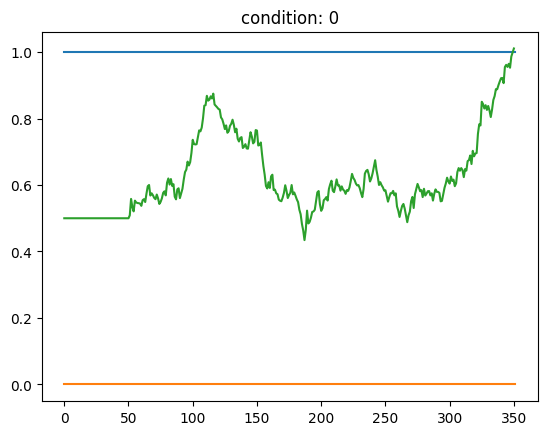

In [ ]:
# Use this for "letting the model run" (sample response)
ddm_H0.generate_trajectory(plausible=0)

# We can inspect the last trajectory by calling the respective method of
# DDM-objects.
# Generating a new trajectory will overwrite the last one.
ddm_H0.plot_last_trajectory()

Lets use this to get an impression of the impact of different plausibility conditions on our H1 model. We will probably only see "correct" responses (up) for both conditions, given the decent amounts of noise that is used. However, the higher z0 in the plausible condition, should (in most cases) result in a much faster reaction time.

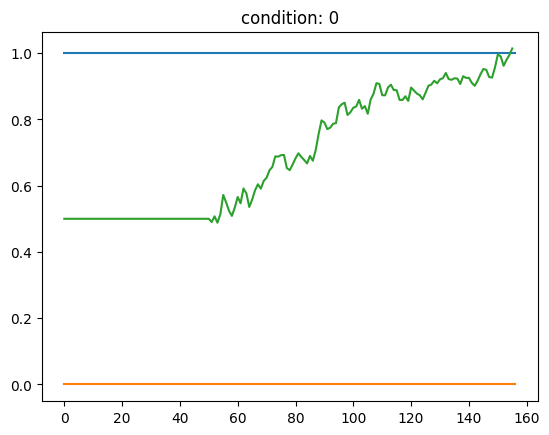

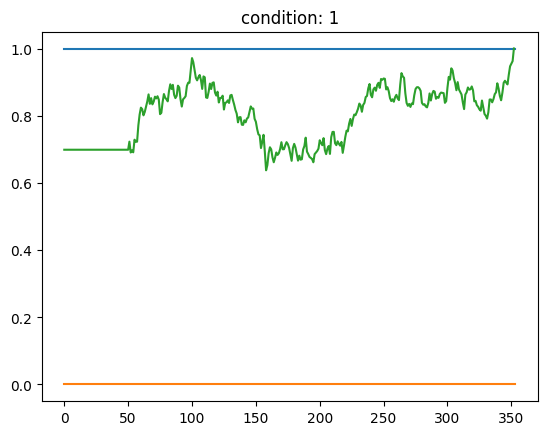

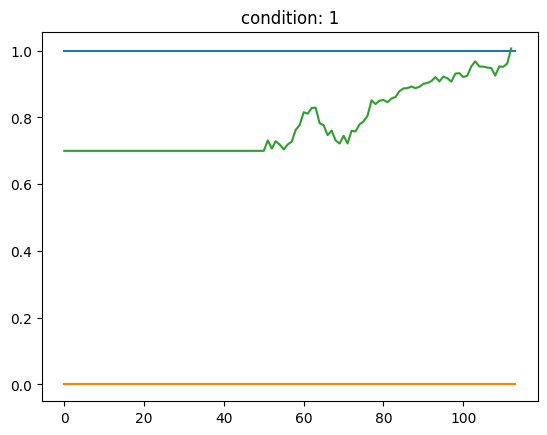

In [ ]:
ddm_H1.generate_trajectory(plausible=0)
ddm_H1.plot_last_trajectory()
ddm_H1.generate_trajectory(plausible=1)
ddm_H1.plot_last_trajectory()

# if working with datasets, in might be more convenient to provide the dummy encoded values
ddm_H1.generate_trajectory(conditions={"RainDropDown":1, "RainDropUp":0})
ddm_H1.plot_last_trajectory()

Model 2 also results in faster reaction times for the plausible condition. So for comparing the models, we will need to take the actual distribution of rts over conditions into account, which is not possible by simply vizually inspecting exemplar trajectories. However, this shows that the more general hypothesis "plausible stimulus -> faster rt" can be found in both models.

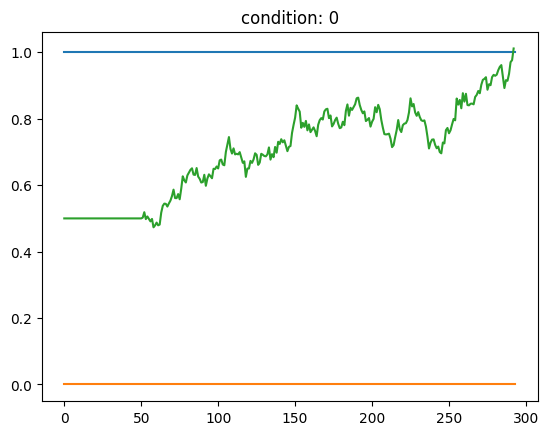

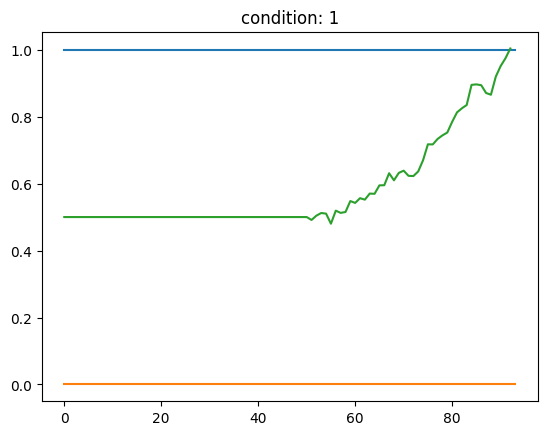

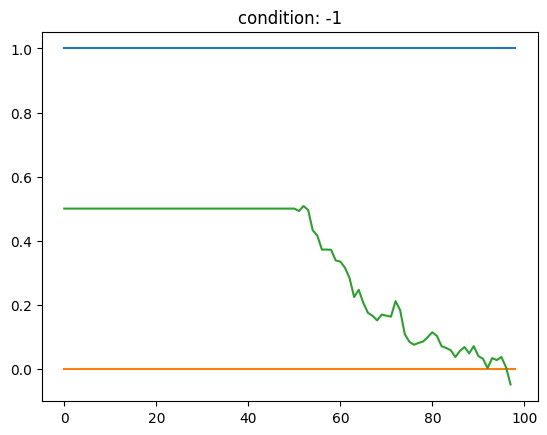

In [ ]:
ddm_H2.generate_trajectory(plausible=0)
ddm_H2.plot_last_trajectory()
ddm_H2.generate_trajectory(plausible=1)
ddm_H2.plot_last_trajectory()
#What does the model do in unplausible conditions? -> less drift, more likely wrong decision, potentially longer rts (depending on signal/noise given choice of beta and drift)
ddm_H2.generate_trajectory(plausible=-1)
ddm_H2.plot_last_trajectory()

### Inspecting Output Distributions over RTs, Conditions and Responses

Now lets check out the reaction time distributions that our models predict. First, we inspect how these look for the natural data, to get an impression about what we are trying to model:

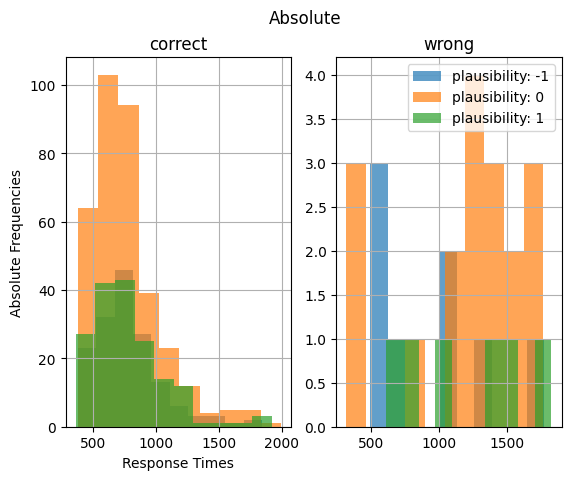

<ipython-input-16-cebc01c3229d>:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  norm[i]=np.array([len(self.log[self.log["plausible"]==condition])])


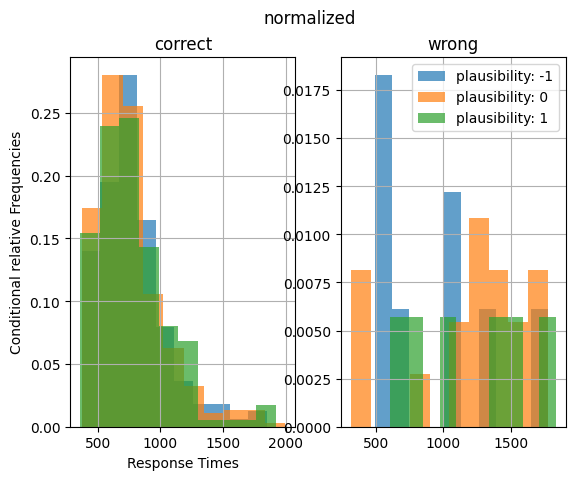

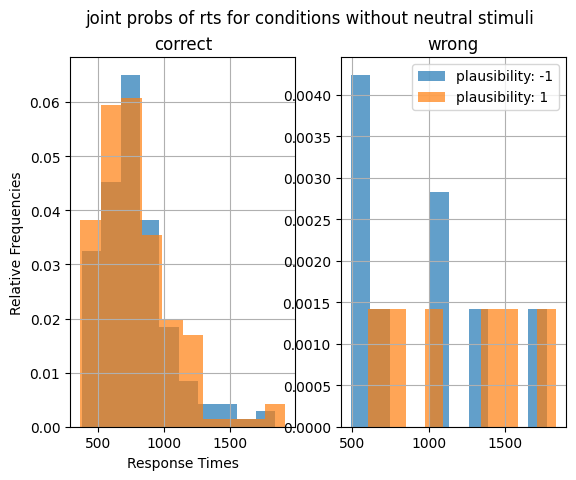

In [ ]:
ddm=DDM(0,0,0,0,0,0) # Dummy ddm because the plotting function isn't static
ddm.log=df

# absolute frequencies, not really helpful
ddm.plot_histogram(title="Absolute")

# since the data is impalanced wrt the conditions, we normalize over the marginal probabilities (i.e. plot p(rt| plausibility))
ddm.plot_histogram(normalize="marginal", title="normalized")

# If plots are too cluttered, we can focus on a subset of conditions
# Also, if we are interested in the ratio of the marginal probabilities of conditions, we can normalize over the whole dataset, i.e. plot joint probabilities p(rt, plausibility)
ddm.plot_histogram(normalize="joint", title="joint probs of rts for conditions without neutral stimuli", conditions=[-1,1])

And now we compare this to our model simulations (for direct comparisons, please use the next cell). There are still many differences, so there is lots to do for the parameter recovery. We predict emergence of:
- a lower drift rate, so that the distributions become flatter
- a much lower signal-to-noise ratio (i.e. also lower absolute drift rate, since we keep noise constant), so that wrong reactions will occur.
- a larger $nrt$, since the simulated data seems shifted to the left. However, some of the shift will already be accounted for by the "slower" drift rate
- a dependence coefficient close to 0 for both conditions, because there seems to be no difference in rts in the behavioural data (i.e. rejecting our hypotheses)
- A new value for upper threshold $a$ and a $z0$ that is scaled accordingly, in order to account for the different drift rate

<ipython-input-63-a7522ad34dc2>:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  norm[i]=np.array([len(self.log[self.log["plausible"]==condition])])


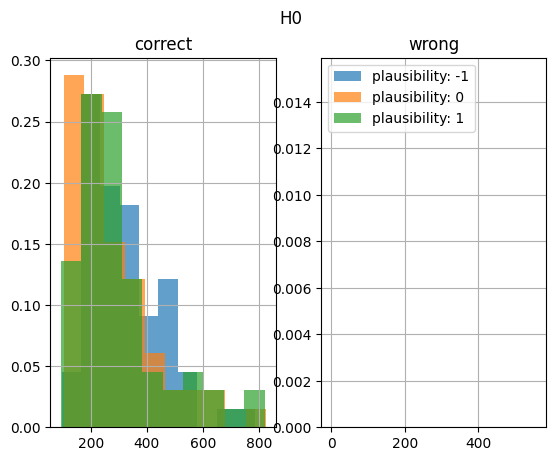

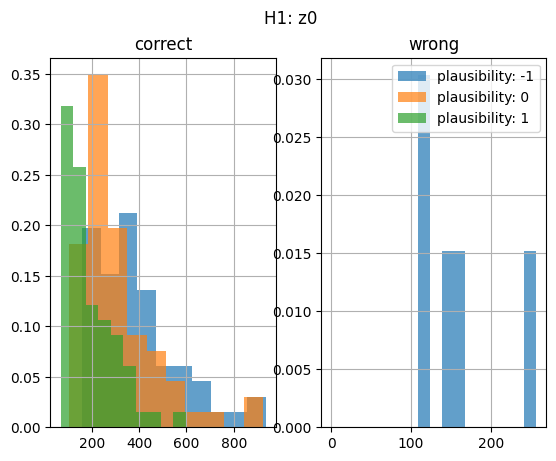

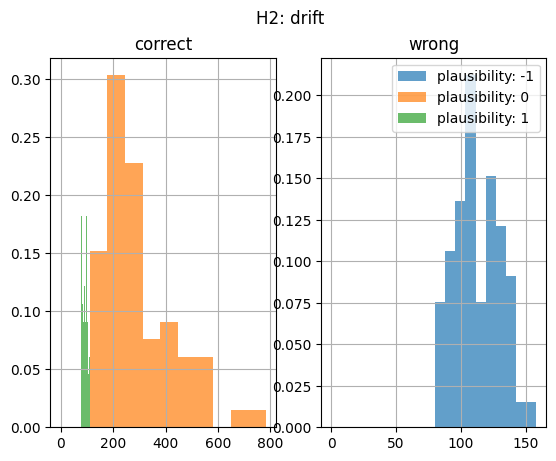

In [ ]:
ddm_H0.reset()
ddm_H1.reset()
ddm_H2.reset()

sample_size=200
conditions=np.r_[-np.ones(sample_size//3), np.zeros(sample_size//3), np.ones(sample_size//3)]
np.random.shuffle(conditions) #finally a real inplace function, gotta love it, screw pandas :D

for plausibility in conditions:
  ddm_H0.generate_trajectory(plausibility)
  ddm_H1.generate_trajectory(plausibility)
  ddm_H2.generate_trajectory(plausibility)

# We can inspect the last trajectory by calling the respective method of DDM-objects
ddm_H0.plot_histogram(normalize="marginal", title="H0", conditions=[-1,0,1])
ddm_H1.plot_histogram(normalize="marginal", title="H1: z0")
ddm_H2.plot_histogram(normalize="marginal", title="H2: drift")

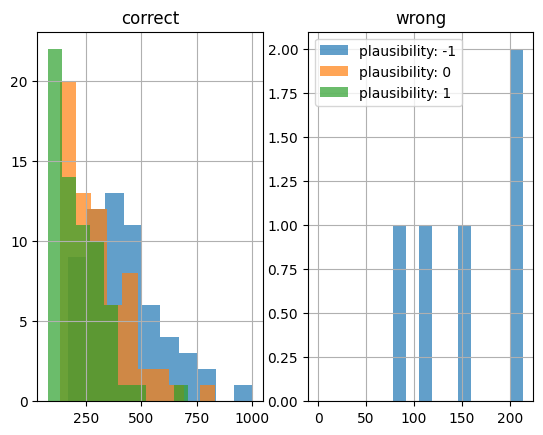

In [ ]:
ddm_H1.plot_histogram()

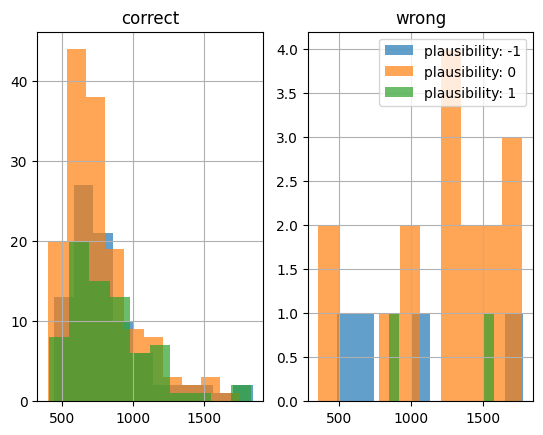

In [ ]:
ddm.plot_histogram()

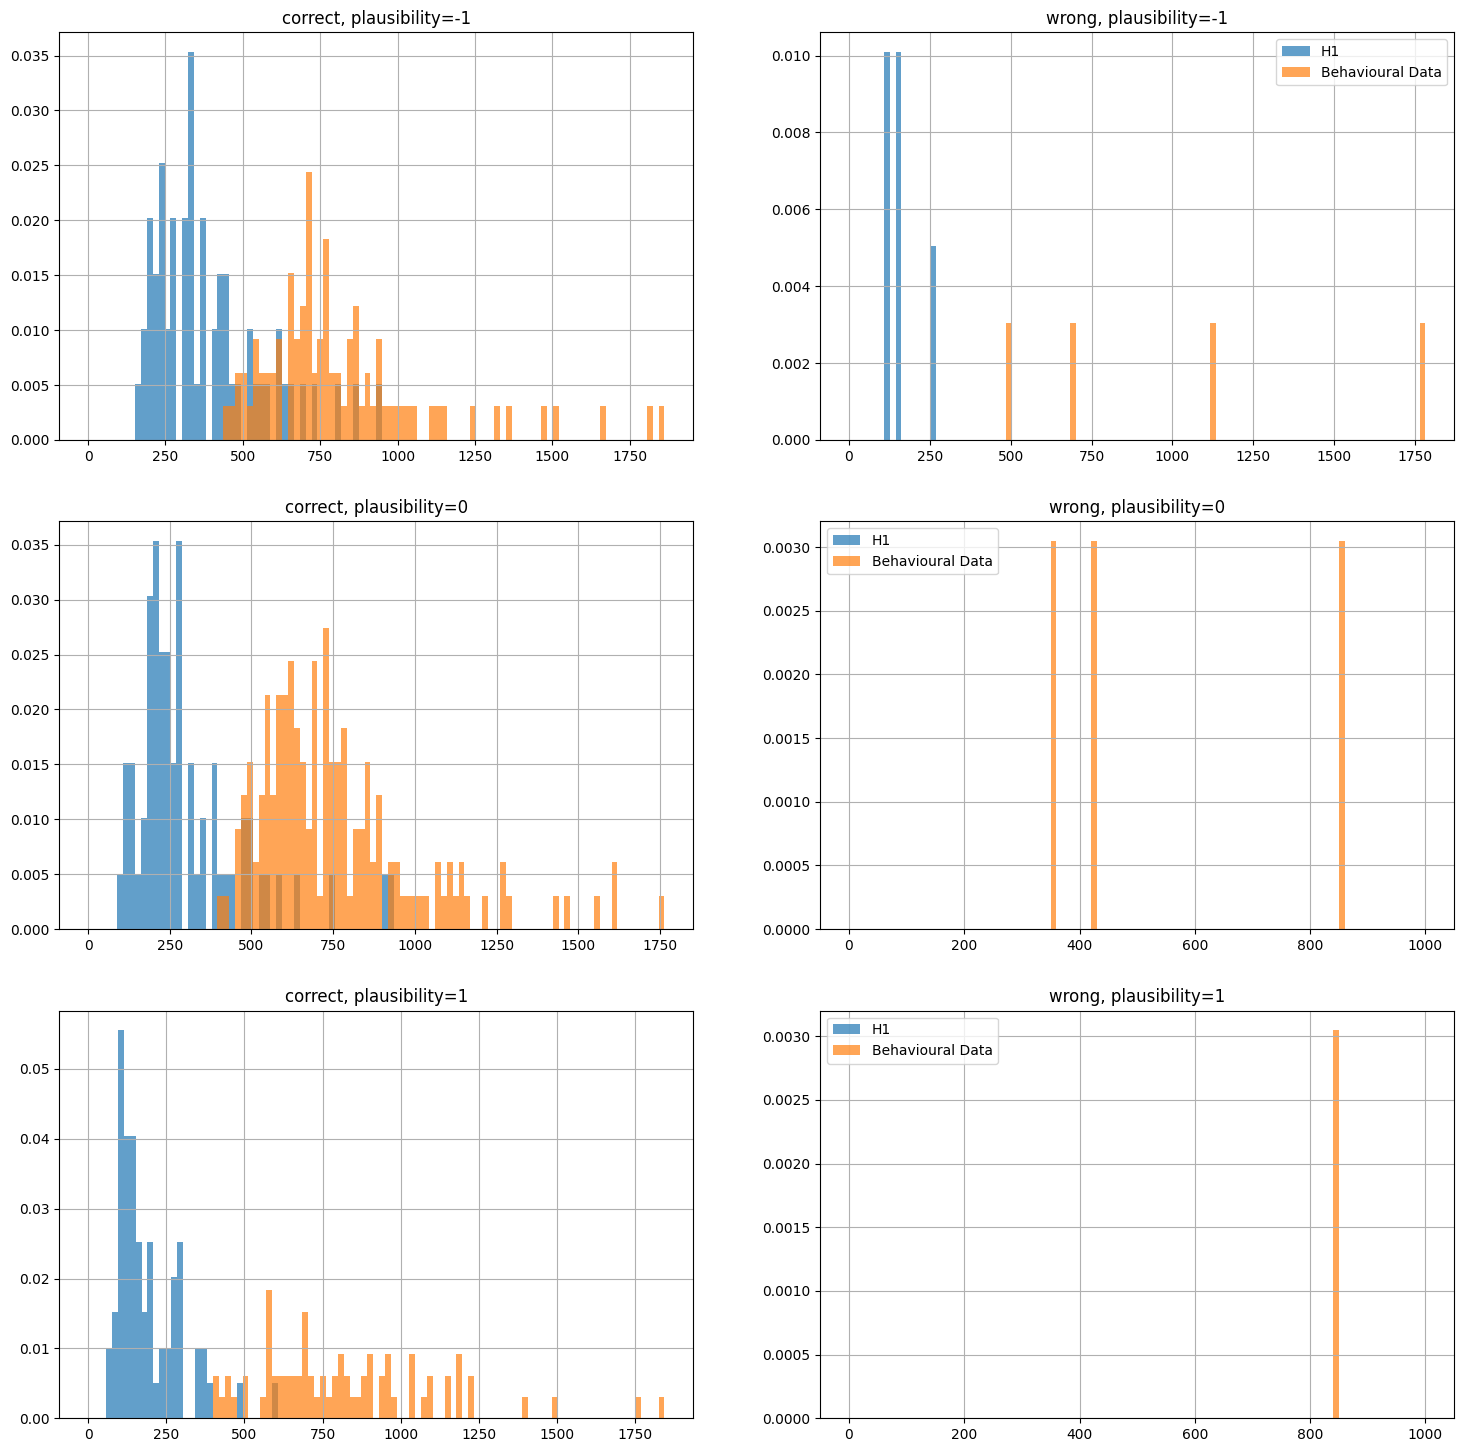

In [ ]:
ddm_H1.compare(ddm.log, conditions=[-1, 0, 1], names=("H1","Behavioural Data"))

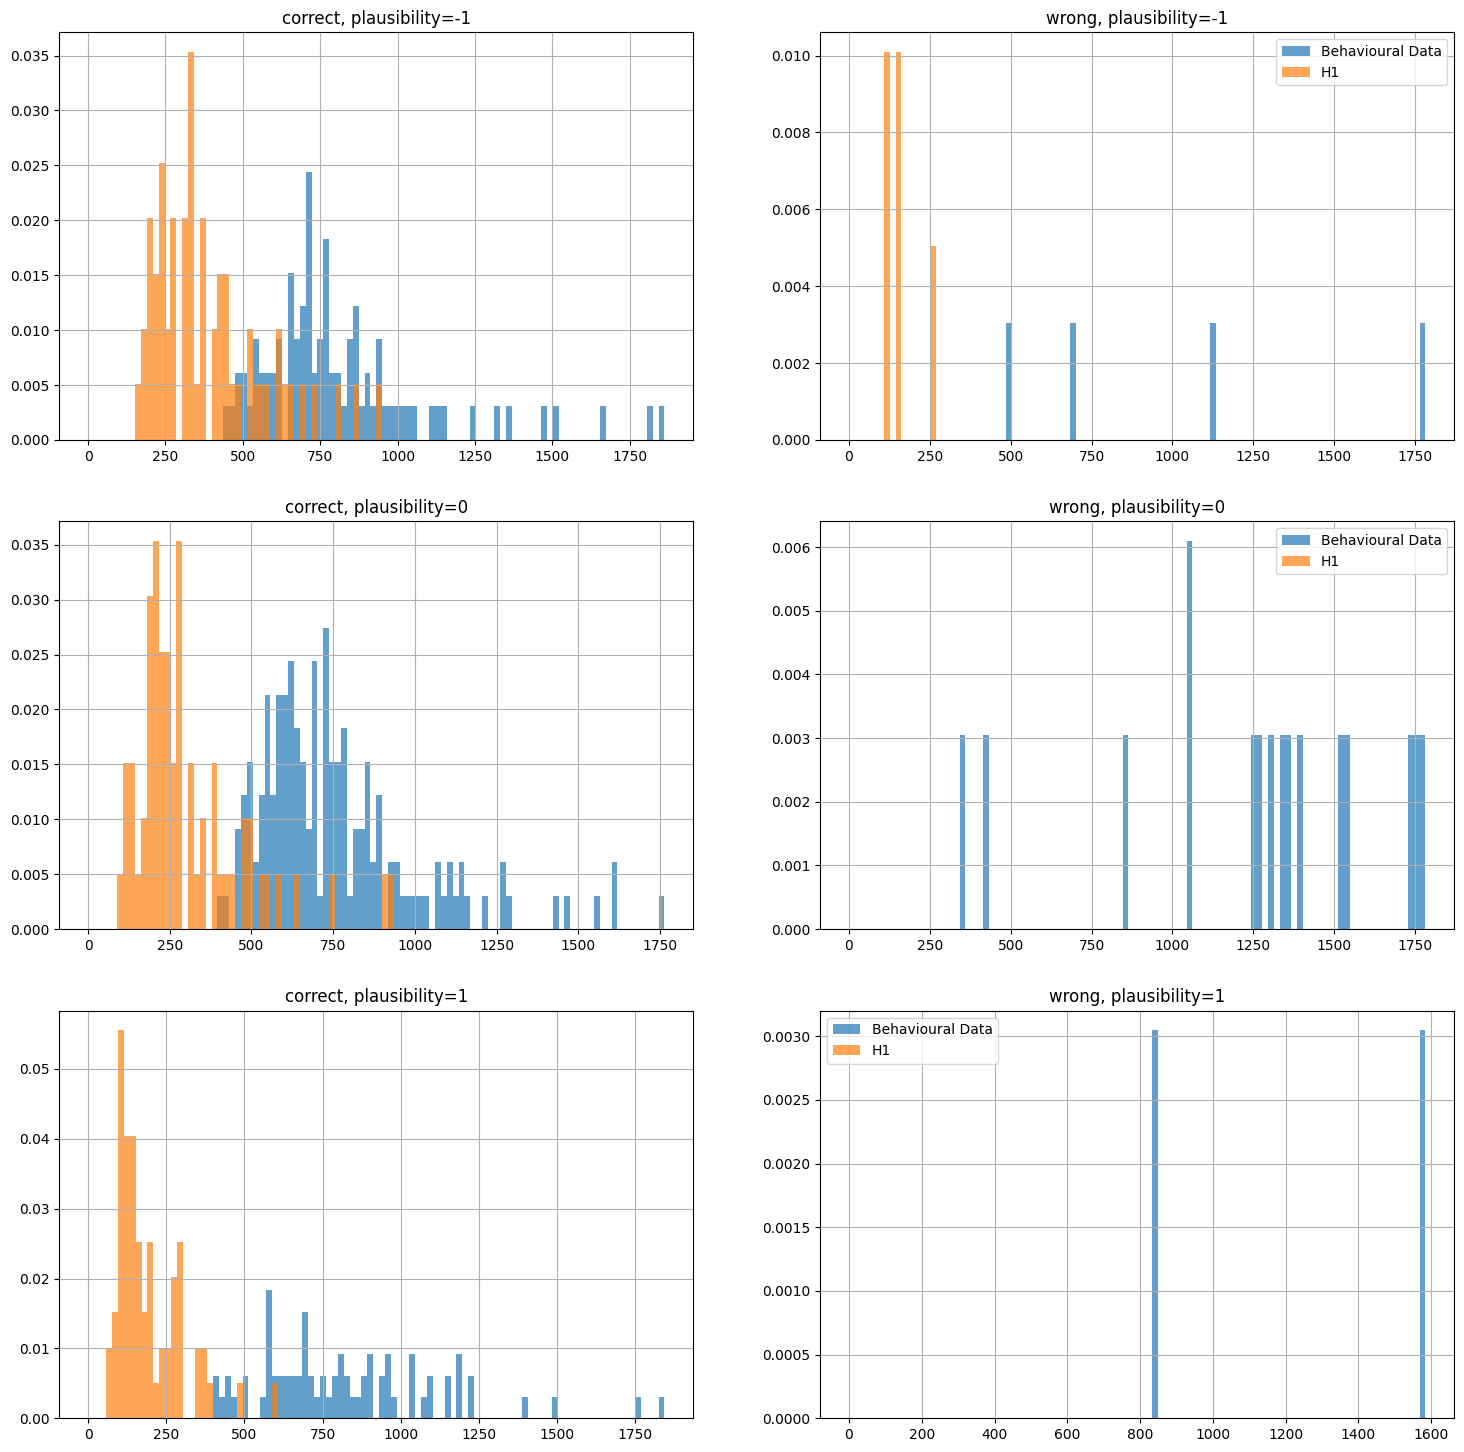

In [ ]:
# for a direct comparison of distributions, use the compare function of the ddm
ddm.compare(ddm_H1.log, conditions=[-1, 0, 1], names=("Behavioural Data", "H1"))

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [ ]:
!pip install arviz
!pip install --upgrade numpyro
!pip install --upgrade arviz numpyro
!pip install --upgrade numpyro numpy scipy
!pip install --upgrade setuptools
!pip install hssm
!pip install scipy

  Using cached numpyro-0.13.2-py3-none-any.whl (312 kB)
  Attempting uninstall: numpyro
    Found existing installation: numpyro 0.12.1
    Uninstalling numpyro-0.12.1:
      Successfully uninstalled numpyro-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hssm 0.2.0 requires numpyro<0.13.0,>=0.12.1, but you have numpyro 0.13.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.14.0
    Uninstalling arviz-0.14.0:
      Successfully uninstalled arviz-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hssm 0.2.0 requires arviz<0.15.0,>=0.14.0, but you have arviz 0.17.0 which is incompatible.
hssm 0.2.0 require

In [ ]:
import numpy as np
import hssm
import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp
import jax.random
import numpy as np
import pandas as pd


In the following code, firstly, we set the parameters space that would be suitable for our model and dataset. Then, we created a ddm model based on our experimental data, and our parameter space. We extracted from this model, three sub models:

Naive Model: This model is the default ddm model, we used the parameter space without specifying any relation or variations in specific parameters.
Varying The Drift Rate Model: This model assumes that plausibility (RainDrop_Down and RainDrop_up) condition have an effect on the drift rate.
Varying The Starting Point Model: This model assumes that plausibility (RainDrop_Down and RainDrop_up) condition have an effect on the bias.

In [ ]:

# Read the .csv file called "df.csv" which contains the data of all the participants and convert them to a pandas dataframe.

model_data = df.copy()

# change temporal resolution according to what hssm expects
model_data["rt"]=model_data["rt"]/1000
model_data

# Drift Rate - v
param_v = {
    "name": "v",
    "prior": {
        "name": "Uniform",
        "lower": -0.5,
        "upper": 0.5,
    },
}

# Threshold - a
param_a = {
    "name": "a",
    "prior": {
        "name": "Uniform",
        "lower": 0.05,
        "upper": 2.0,
    },
    "bounds": (0, float("inf")),
}

# Starting Point - z
param_z = {
    "name": "z",
    "prior": {
        "name": "Uniform",
        "lower": 0.4,
        "upper": 0.6,
    },
}

# Non-Decision Time - t
param_t = {
    "name": "t",
    "prior": {
        "name": "Uniform",
        "lower": 0.1,
        "upper": 0.3,
    },
}

# Create DDM Model
ddm_model = hssm.HSSM(
    data=model_data,
    model="ddm",
    include=[
        param_v,
        param_a,
        param_z,
        param_t,
    ]
)

ddm_model.sample()


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Matrix(float32, shape=(2, ?)) (of Variable Switch.0) into Type Matrix(float64, shape=(2, ?)). You can try to manually convert Switch.0 into a Matrix(float64, shape=(2, ?)). local_mul_switch_sink
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_mul_switch_sink
ERROR:pytensor.graph.rewriting.basic:node: Mul(Eq.0, Switch.0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pytensor/graph/features.py", line 571, in r

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Here, we implement Naive Model with 2 chains, and each consisting of 2000 draws. An additional 2000 tuning steps were performed:

In [ ]:
# implementing naive model
naive_model = hssm.HSSM(
    data=model_data,
)
naive_model_inference = naive_model.sample(
     sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
     cores=1,                # the number of CPU cores used to run MCMC sampling
     chains=2,               # the number of independent "runs" we sample through the room of parameters
     draws=2000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
     tune=2000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
     idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
 )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Here, we visualize the architecture of the model to get information about the relations between the different parameters.
(opinion about the results)

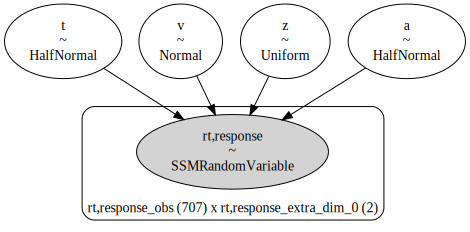

In [ ]:
naive_model.graph()

Here, we try to trace the fitting of each parameter for Varying The Naive Model and assess whether they have converged to the target distribution. For this purpose, we used trace plots from ARviz library.

(opinion about the results)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


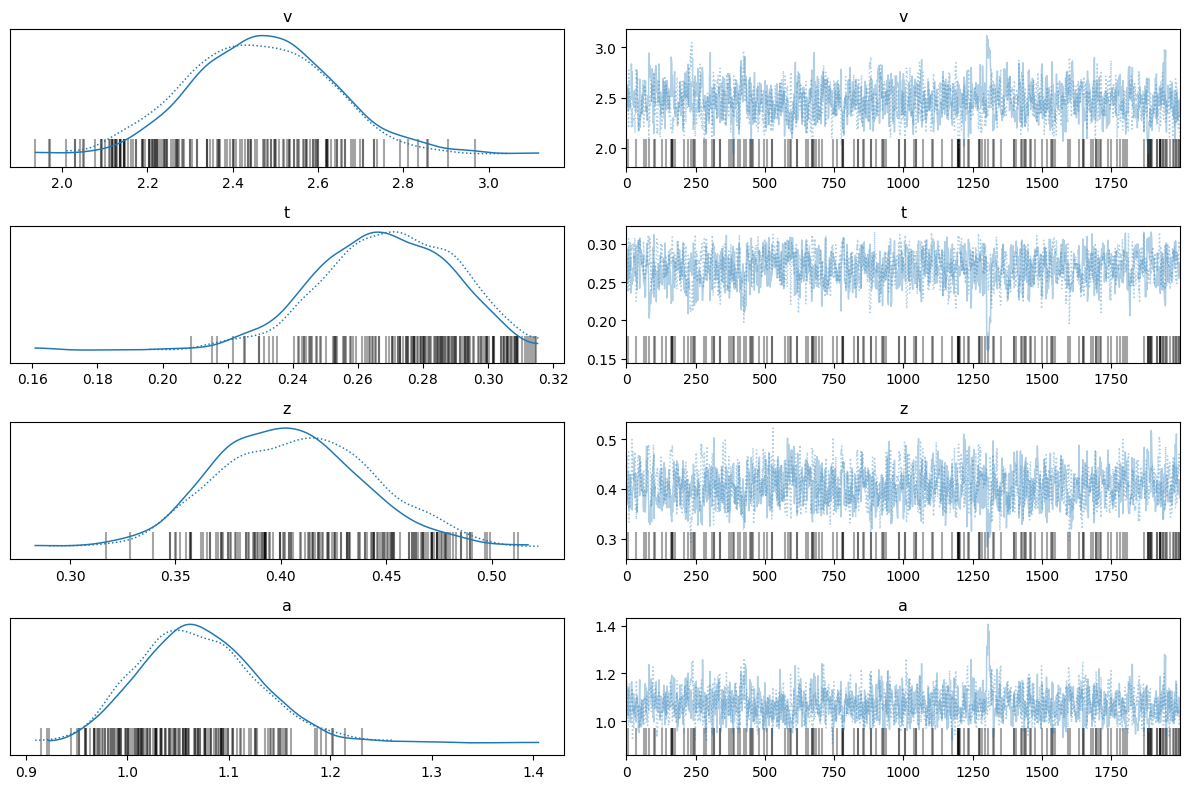

In [ ]:
naive_model.plot_trace()

The following table represents the results of the mcmc bayesian analysis for the naive model in which:

1.  Mean: The mean of the posterior distribution for each parameter.
2.  Sd: The standard deviation of the posterior distribution.
3.  hdi_3%: The lower bound of the 94% Highest Density Interval (HDI) for the parameter (equivalent to the 3rd percentile).
4.  hdi_97%: The upper bound of the 94% HDI for the parameter (equivalent to the 97th percentile).
5.  mcse_mean: The estimated standard error of the mean.
6.  mcse_sd: The estimated standard error of the standard deviation.
7.  ess_bulk: The effective sample size of the bulk samples.
8. ess_tail: The effective sample size of the tail samples.
9.  r_hat: The Gelman-Rubin statistic (potential scale reduction factor), which assesses convergence of the Markov chains. Values close to 1 (e.g., less than 1.1) indicate convergence.

(opinion about the results)

In [ ]:
az.summary(naive_model.traces)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  2.467  0.164   2.154    2.765      0.006    0.004     729.0     998.0   
t  0.268  0.021   0.233    0.308      0.001    0.001     701.0     986.0   
z  0.406  0.035   0.346    0.476      0.001    0.001     836.0    1311.0   
a  1.070  0.059   0.964    1.178      0.002    0.002     856.0    1112.0   

   r_hat  
v   1.00  
t   1.01  
z   1.01  
a   1.00

Here, we implement Varying The Drift Rate Model with 2 chains, and each consisting of 2000 draws. An additional 2000 tuning steps were performed. In line with our hypothesis, the formula "v ~ 1 + RainDropDown + RainDropUp" specifies how the variable v is modeled based on the movement of rain drops and how participants reacted to them.

In [ ]:
# implementing model with varying the drift_value (v)
varying_drift_model = hssm.HSSM(
    data=model_data,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

varying_drift_model_inference = varying_drift_model.sample(
     sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
     cores=1,                # the number of CPU cores used to run MCMC sampling
     chains=2,               # the number of independent "runs" we sample through the room of parameters
     draws=2000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
     tune=2000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
     idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
 )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Here, we visualize the architecture of the model to get information about the relations between the different parameters. (opinion about the results)

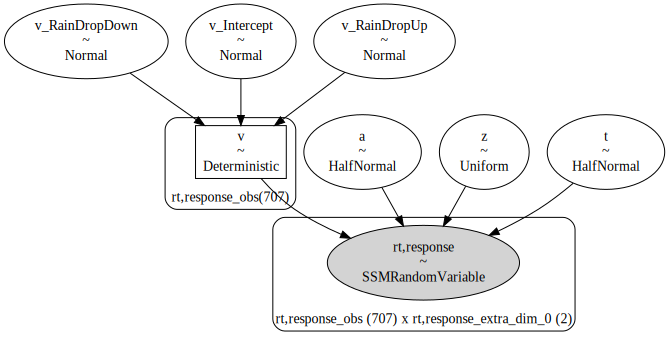

In [ ]:
varying_drift_model.graph()

Here, we try to trace the fitting of each parameter for Varying The Drift Rate Model and assess whether they have converged to the target distribution. For this purpose, we used trace plots from ARviz library.

(opinion about the results)

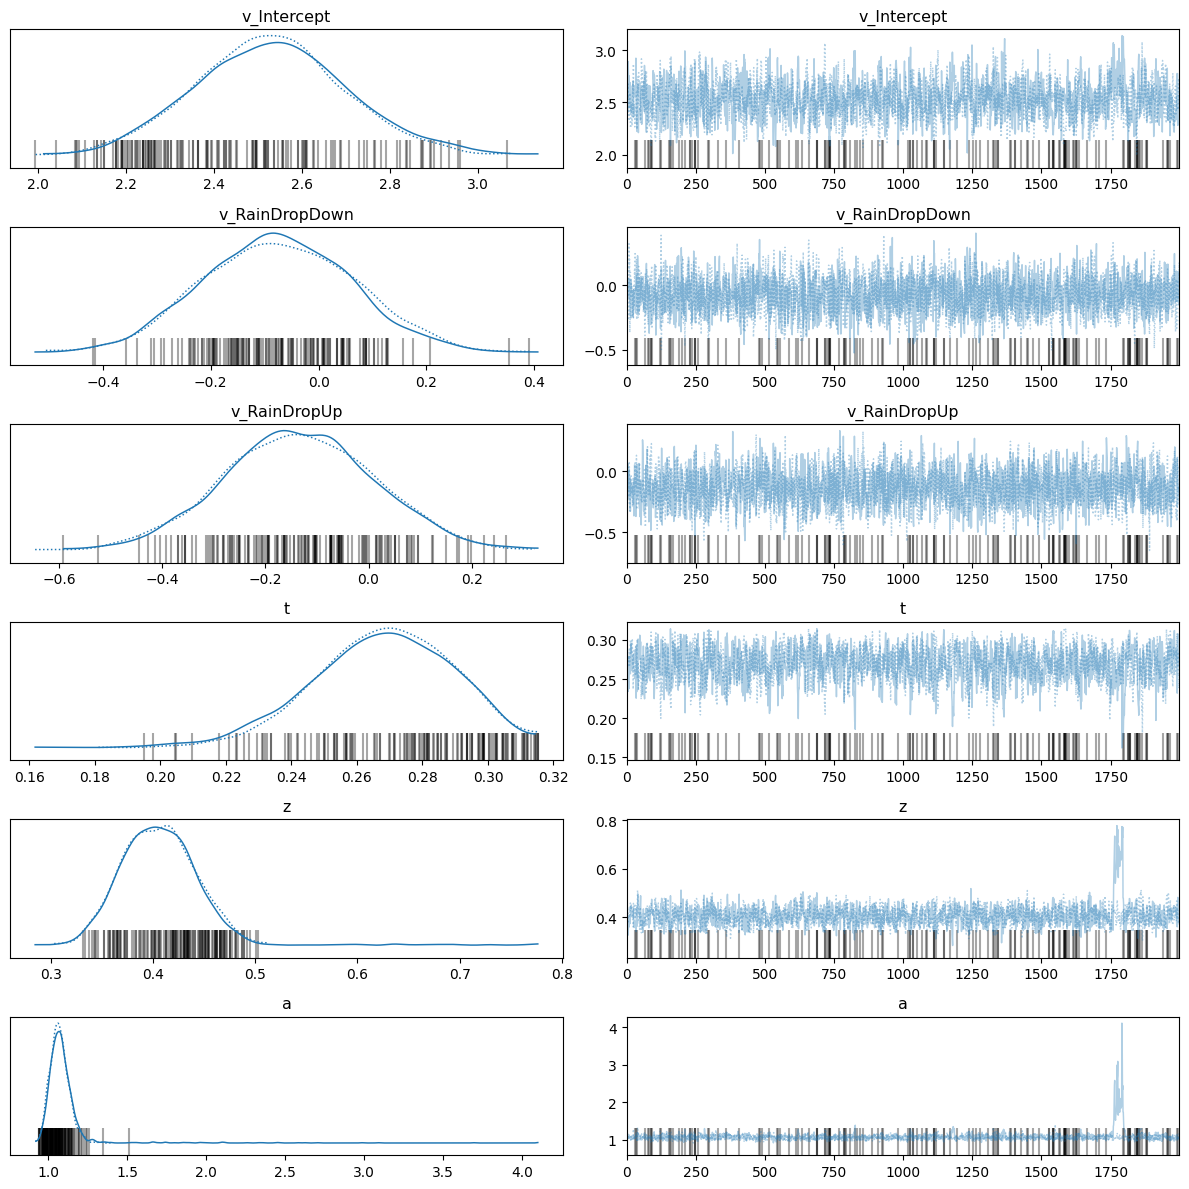

In [ ]:
varying_drift_model.plot_trace()

The following table represents the results of the mcmc bayesian analysis for the naive model in which:

1.  Mean: The mean of the posterior distribution for each parameter.
2.  Sd: The standard deviation of the posterior distribution.
3.  hdi_3%: The lower bound of the 94% Highest Density Interval (HDI) for the parameter (equivalent to the 3rd percentile).
4.  hdi_97%: The upper bound of the 94% HDI for the parameter (equivalent to the 97th percentile).
5.  mcse_mean: The estimated standard error of the mean.
6.  mcse_sd: The estimated standard error of the standard deviation.
7.  ess_bulk: The effective sample size of the bulk samples.
8. ess_tail: The effective sample size of the tail samples.
9.  r_hat: The Gelman-Rubin statistic (potential scale reduction factor), which assesses convergence of the Markov chains. Values close to 1 (e.g., less than 1.1) indicate convergence.

(opinion about the results)

In [ ]:
az.summary(varying_drift_model.traces)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept     2.530  0.172   2.201    2.853      0.005    0.004    1128.0   
v_RainDropDown -0.075  0.139  -0.325    0.191      0.003    0.002    2605.0   
v_RainDropUp   -0.135  0.146  -0.404    0.140      0.003    0.002    2321.0   
t               0.268  0.022   0.229    0.307      0.001    0.000    1105.0   
z               0.407  0.042   0.336    0.468      0.002    0.002    1059.0   
a               1.083  0.130   0.964    1.189      0.010    0.007     841.0   

                ess_tail  r_hat  
v_Intercept       1658.0    1.0  
v_RainDropDown    2572.0    1.0  
v_RainDropUp      2824.0    1.0  
t                 1281.0    1.0  
z                  527.0    1.0  
a                  357.0    1.0

Here, we implement Varying The Bias Model with 2 chains, and each consisting of 2000 draws. An additional 2000 tuning steps were performed. In line with our hypothesis, the formula "z ~ 1 + RainDropDown + RainDropUp" specifies how the variable z is modeled based on the movement of rain drops and how participants reacted to them.

In [ ]:
# implementing model with varying bias (z)
varying_bias_model = hssm.HSSM(
    data=model_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

varying_bias_model_inference = varying_bias_model.sample(
     sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
     cores=1,                # the number of CPU cores used to run MCMC sampling
     chains=2,               # the number of independent "runs" we sample through the room of parameters
     draws=2000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
     tune=2000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
     idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
 )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Here, we visualize the architecture of the model to get information about the relations between the different parameters. (opinion about the results)

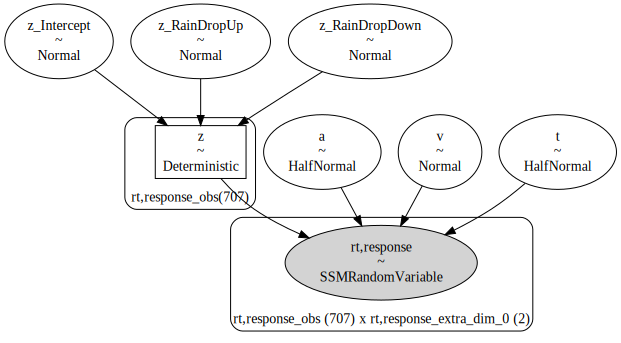

In [ ]:
varying_bias_model.graph()

Here, we try to trace the fitting of each parameter for Varying The Bias Model and assess whether they have converged to the target distribution. For this purpose, we used trace plots from ARviz library.

(opinion about the results)

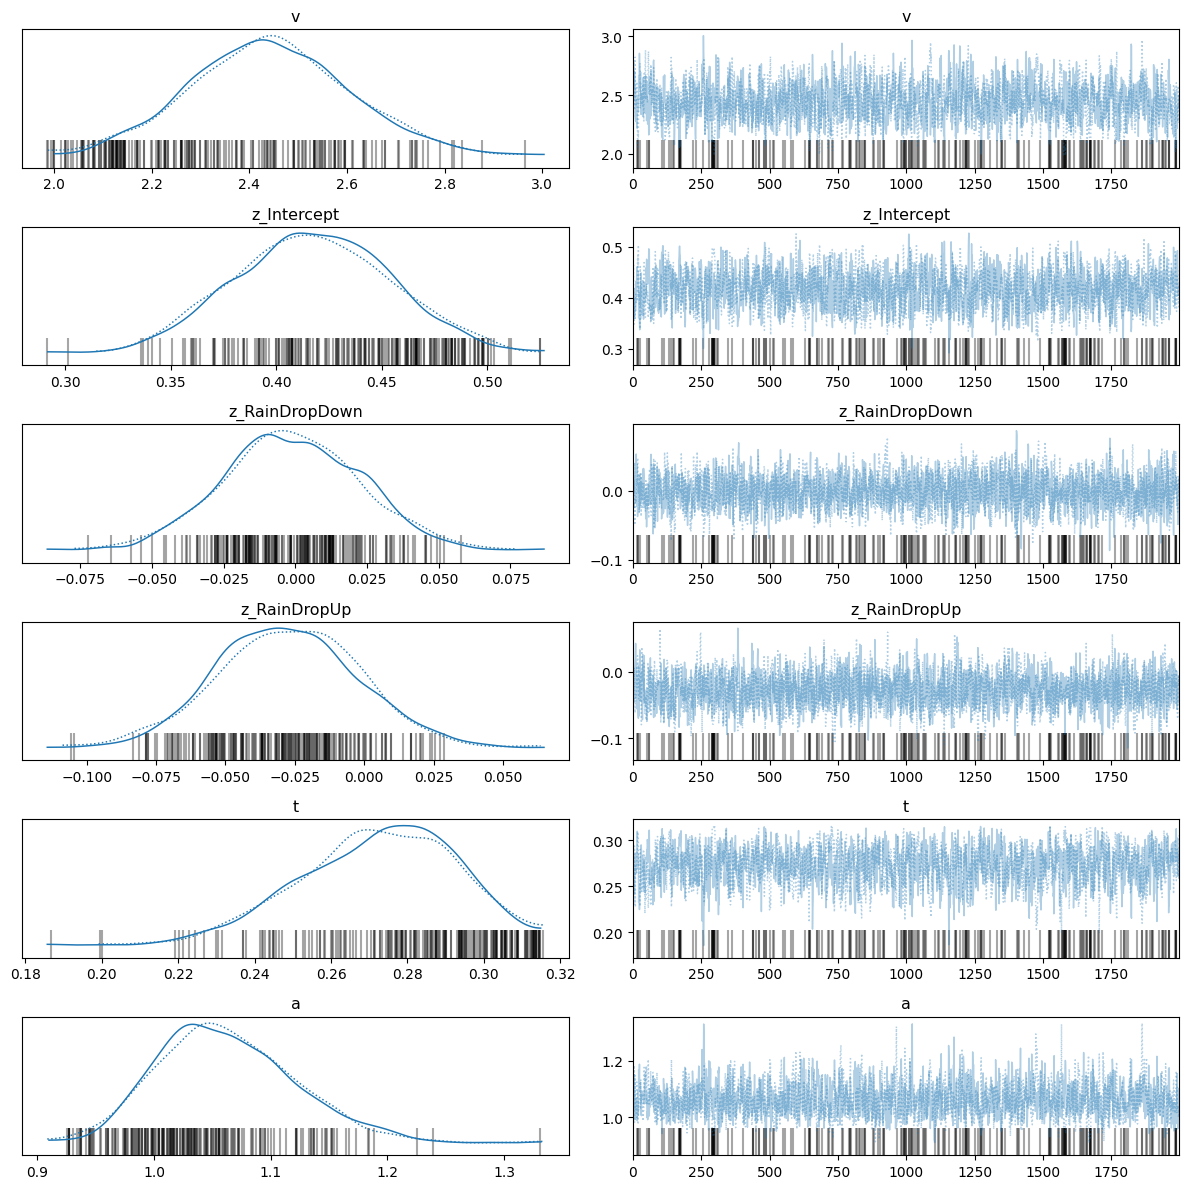

In [ ]:
varying_bias_model.plot_trace()

The following table represents the results of the mcmc bayesian analysis for the naive model in which:

1.  Mean: The mean of the posterior distribution for each parameter.
2.  Sd: The standard deviation of the posterior distribution.
3.  hdi_3%: The lower bound of the 94% Highest Density Interval (HDI) for the parameter (equivalent to the 3rd percentile).
4.  hdi_97%: The upper bound of the 94% HDI for the parameter (equivalent to the 97th percentile).
5.  mcse_mean: The estimated standard error of the mean.
6.  mcse_sd: The estimated standard error of the standard deviation.
7.  ess_bulk: The effective sample size of the bulk samples.
8. ess_tail: The effective sample size of the tail samples.
9.  r_hat: The Gelman-Rubin statistic (potential scale reduction factor), which assesses convergence of the Markov chains. Values close to 1 (e.g., less than 1.1) indicate convergence.

(opinion about the results)

In [ ]:
az.summary(varying_bias_model.traces)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v               2.443  0.161   2.120    2.730      0.005    0.003    1168.0   
z_Intercept     0.417  0.036   0.354    0.489      0.001    0.001    1344.0   
z_RainDropDown -0.001  0.024  -0.045    0.046      0.000    0.000    2560.0   
z_RainDropUp   -0.028  0.026  -0.076    0.020      0.001    0.000    2281.0   
t               0.272  0.020   0.235    0.309      0.001    0.000    1094.0   
a               1.062  0.059   0.959    1.174      0.002    0.001    1329.0   

                ess_tail  r_hat  
v                 1571.0    1.0  
z_Intercept       1743.0    1.0  
z_RainDropDown    2391.0    1.0  
z_RainDropUp      2233.0    1.0  
t                 1671.0    1.0  
a                 1792.0    1.0

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





Here I implemented our above model implination again in the same order, but I made a few parameters dynamic(means we can feed them as an imput to the model), so that I can generate simulate data.

In [ ]:
#individual implementation
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)

class DDM:
  def __init__(self, z0, drift, noise, nrt, dependence_offset, dependence_coefficient, dependent_variable, t_upper, t_lower, max_timesteps=1000):
    self.z0=z0
    self.drift=drift
    self.t_upper=t_upper
    self.t_lower=t_lower
    self.noise=noise
    self.nrt=nrt
    self.dependence_offset=dependence_offset
    self.dependence_coefficient=dependence_coefficient
    self.dependent_variable=dependent_variable
    self.max_timesteps=max_timesteps
    self.log=pd.DataFrame(columns=("condition", "rt", "response"))

  def get_noise(self):
    return np.random.normal(0,self.noise)

  def generate_trajectory(self, condition):
    '''
    Simulates a trajectory according to the ddm.

      Parameters:
        condition (int): In our case: 1=down is correct answer, -1=up is correct answer

      Returns:
        result Tuple(int, int): result, consisting of rt and correctness
    '''
    t=self.nrt
    z=self.z0
    self.last_condition=condition
    if self.dependent_variable=="z0":
      #z0 already is the offset, so we donot need an explicit offset
      z+=condition*self.dependence_coefficient
    self.trajectory=[z]
    while not z>=self.t_upper and not z<self.t_lower and not t>self.max_timesteps:
      t+=1
      z+=self.get_noise()
      if self.dependent_variable=="drift":
        z+=self.drift*(self.dependence_offset+condition*self.dependence_coefficient)
      else:
        z+=self.drift
      self.trajectory.append(z)

    if z>=self.t_upper:
      response = 1
    elif z<=self.t_lower:
      response = -1
    else:
      response = 0

    self.log = pd.concat([self.log, pd.DataFrame({"condition": [condition], "rt": [t], "response": [response]})], ignore_index=True)


    return t, response

  def plot_last_trajectory(self):
    plt.plot((0,len(self.trajectory)+self.nrt),[self.t_upper, self.t_upper])
    plt.plot((0,len(self.trajectory)+self.nrt),[self.t_lower, self.t_lower])
    plt.plot(np.r_[[0], np.arange(len(self.trajectory))+self.nrt],np.r_[self.trajectory[0], self.trajectory])
    plt.title(f"condition: {self.last_condition}")
    plt.show()

  def plot_histogram(self, conditional=False):
    if not conditional:
      fig, axs = plt.subplots(1, 2)
      self.log[self.log["response"]==1]["rt"].hist(ax=axs[0])
      axs[0].title.set_text("correct")
      self.log[self.log["response"]==-1]["rt"].hist(ax=axs[1])
      axs[1].title.set_text("wrong")
      plt.show()
    else:
      fig, axs = plt.subplots(1, 2)
      self.log[(self.log["response"]==1) & (self.log["condition"]==-1)]["rt"].hist(ax=axs[0], label='condition: -1', alpha=0.7)
      self.log[(self.log["response"]==1) & (self.log["condition"]==1)]["rt"].hist(ax=axs[0], label='condition: 1', alpha=0.7)
      axs[0].title.set_text("correct")
      self.log[(self.log["response"]==-1) & (self.log["condition"]==-1)]["rt"].hist(ax=axs[1], label='condition: -1', alpha=0.7)
      self.log[(self.log["response"]==-1) & (self.log["condition"]==1)]["rt"].hist(ax=axs[1], label='condition: 1', alpha=0.7)
      axs[1].title.set_text("wrong")
      plt.legend()
      plt.show()


z0=0.5
drift=0.001
noise=0.07
nrt=50
dependence_offset=1
dependence_coefficient=0#these two values mean "no dependence"
dependent_variable="drift"

#these values should be fine
t_upper=1
t_lower=0
max_timesteps=1000

ddm=DDM(z0, drift, noise, nrt, dependence_offset, dependence_coefficient, dependent_variable, t_upper, t_lower, max_timesteps)

Below, I made two funtions-


*   One is for generating the simiulate data using our implimented model.
*   Second one is for fitting the model, I feed the value of the threshold(a),  at the time of feeding, as I found that the parameter a is non recoverable when we performed the model fitting.



In [ ]:
import numpy as np
import pandas as pd
import random
import hssm

def simulate_data(model_name, param_values):
    """
    Simulates data for the Drift-Diffusion Model (DDM) with given parameter values.

    Parameters:
        model_name (str): Name of the model (should be "DDM").
        param_values (dict): Dictionary containing parameter names as keys and their corresponding values.

    Returns:
        simulated_data: Simulated data generated by the DDM.
    """
    if model_name != "DDM":
        raise ValueError("Model name must be 'DDM'.")


    z0= param_values['z']
    drift=param_values['v']
    noise=0.181
    nrt= 3
    t_lower = z0 - 1.2/2
    t_upper = z0 + 1.2/2
    dependence_offset=1
    dependence_coefficient=1#these two values means the model is dependent on the type of stimuli
    dependent_variable="drift"
    max_timesteps=1000

    # Simulate response times using the DDM equation
    # Replace this with actual DDM simulation code
    ddm=DDM(z0, drift, noise, nrt, dependence_offset, dependence_coefficient, dependent_variable, t_upper, t_lower, max_timesteps)

    total_response_times = []
    response_total = []
    conditions = []
    for _ in range(500):

      stimuli_types = [-1,0,1]
      condition = random.choice(stimuli_types)

      response_times, response= ddm.generate_trajectory(condition)

      total_response_times.append(response_times)
      response_total.append(response)
      conditions.append(condition)

    df = pd.DataFrame(list(zip(total_response_times, response_total, conditions)), columns=['rt', 'response', 'plausible'])
    return df


def fit_model(model_name, data):
    """
    Fits the Drift-Diffusion Model (DDM) to the provided data.

    Parameters:
        data: Observed response times, responses, and stimule(RainDrop) movements.
        model_name (str): Name of the model (should be "DDM").

    Returns:
        fitted_models: Fitted parameters with the three models.
    """
    if model_name != "DDM":
        raise ValueError("Model name must be 'DDM'.")


    model_reg_v = hssm.HSSM(
        data=data,
        model="ddm",

        include=[
            {
                "name": "v",
                "formula": "v ~ 1 + RainDropUp + RainDropDown",
            }
        ],
    )

    model_reg_z = hssm.HSSM(
        data=data,
        model="ddm",

        include=[
            {
                "name": "z",
                "formula": "z ~ 1 + RainDropUp + RainDropDown",
            }
        ],
    )

    model_reg_n = hssm.HSSM(
        data=data,
        model="ddm",

    )
    trace_reg_v = model_reg_v
    trace_reg_z = model_reg_z
    trace_reg_n = model_reg_n
    return trace_reg_v, trace_reg_z, trace_reg_n



In the code block below, I defined a suitable parameter space. I tried to draw four sets of parameter sets(v,t,z) from the mentioned space, and generated 4 simulated dataset using the above funtions.

Then I fitted all 4 generated datset using the fit_model function above, to get the posterior distribution of the true parameters.

In [ ]:
# Define the parameter space for the DDM model
import random
import numpy as np

param_space = {
    'v': (0.012, 0.009),  # Drift rate
    't': (3, 4),  # Non-decision time,
    'z': (0.49, 0.51), # starting point
}

num_true_values = 4 # number of true values drawn from the parameter set to gerate dataset
true_values = []
dfs = {}

for i in range(num_true_values):

  def sample_params(space):
      return {param: np.random.uniform(low, high) for param, (low, high) in space.items()}

  true_values.append(sample_params(param_space))

  dfs[f'data_{i}'] = simulate_data("DDM", (sample_params(param_space)))




for j, df in enumerate(dfs):
  temp = dfs[df]["plausible"]
  RainDropUp = []
  RainDropDown = []
  for i in range(len(temp)):
    if temp[i] ==0:
      RainDropUp.append(0)
      RainDropDown.append(0)
    elif temp[i] ==1:
      RainDropUp.append(0)
      RainDropDown.append(1)
    else:
      RainDropUp.append(1)
      RainDropDown.append(0)
  dfs[df]["RainDropUp"] = RainDropUp
  dfs[df]["RainDropDown"] = RainDropDown
  print(true_values[j])
  print(dfs[df].head(30))
  num_neg_ones = dfs[df]['response'].value_counts().get(-1, 0)
  print(f"Number of -1 in 'response' column: {num_neg_ones}")


print("Here we can see our model responses")

for df in dfs.values():
    count = len(df[(df['response'] == 1) & (df['plausible'] == -1)])
    print(f"Number of rows where 'response' is 1 and 'plausible' is -1: {count}")
    count = len(df[(df['response'] == -1) & (df['plausible'] == -1)])
    print(f"Number of rows where 'response' is -1 and 'plausible' is -1: {count}")
    count = len(df[(df['response'] == 1) & (df['plausible'] == 1)])
    print(f"Number of rows where 'response' is 1 and 'plausible' is 1: {count}")
    count = len(df[(df['response'] == -1) & (df['plausible'] == 1)])
    print(f"Number of rows where 'response' is -1 and 'plausible' is 1: {count}")


trace_reg_v = {}
trace_reg_z = {}
trace_reg_n = {}
for i, df in enumerate(dfs):
  trace_reg_v[f'trace_reg_v_{i}'], trace_reg_z[f'trace_reg_z_{i}'], trace_reg_n[f'trace_reg_n_{i}'] = fit_model("DDM", dfs[df])




{'v': 0.010922808678216399, 't': 3.349770080167962, 'z': 0.4993532887361709}
    rt  response  plausible  RainDropUp  RainDropDown
0   29         1          0           0             0
1   15        -1          1           0             1
2   26         1          0           0             0
3    5        -1          0           0             0
4   31         1          0           0             0
5   13         1         -1           1             0
6    8         1          0           0             0
7   17         1          0           0             0
8    5        -1          0           0             0
9   23        -1         -1           1             0
10   8        -1         -1           1             0
11  27         1          0           0             0
12   6        -1          0           0             0
13  12         1         -1           1             0
14   8         1         -1           1             0
15  14        -1          1           0             1
16  1

In the result section you can see, that when the reaindrops are moving upword(plausible: -1), almost 50% of the time the model choose the corect answ and 50% of the time it choose wrong answer.

while,  when the reaindrops are moving down(plausible: 1), almost 75% of the time the model predicts the right direction of the movement.

Below, I am doing the sampling of the fitted models to get the posterior probability distribution.

trace_reg_v - varying drift model

trace_reg_z - varying starting point model

trace_reg_n - naive model

In [ ]:
varying_drift_model_inference = {}
for i, model in enumerate(trace_reg_v):
  print(i)
  varying_drift_model_inference[f'varying_drift_model_inference_{i}'] = trace_reg_v[model].sample(
     sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
     cores=1,                # the number of CPU cores used to run MCMC sampling
     chains=3,               # the number of independent "runs" we sample through the room of parameters
     draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
     tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
     idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
 )

0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
varying_drift_model_inference = {}
for i, model in enumerate(trace_reg_z):
  print(i)
  varying_drift_model_inference[f'varying_drift_model_inference_{i}'] = trace_reg_z[model].sample(
     sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
     cores=1,                # the number of CPU cores used to run MCMC sampling
     chains=3,               # the number of independent "runs" we sample through the room of parameters
     draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
     tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
     idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
 )

0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
varying_drift_model_inference = {}
for i, model in enumerate(trace_reg_n):
  print(i)
  varying_drift_model_inference[f'varying_drift_model_inference_{i}'] = trace_reg_n[model].sample(
     sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
     cores=1,                # the number of CPU cores used to run MCMC sampling
     chains=3,               # the number of independent "runs" we sample through the room of parameters
     draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
     tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
     idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
 )

0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:01<?, ?it/s]

For, every fitted model for different true paremeter values, I printed their true parametr values at the time of gernerating the simulated data and their correponding posterior probabitity distribution to check if they are recoverable,i.e. if the true values lie between hdi_3% aand hdi_97% range.

In [ ]:
print("True values: ")
print(true_values[0])
print("Summary of trace_reg_v_0")
print(trace_reg_v["trace_reg_v_0"].summary())
print("True values: ")
print(true_values[1])
print("Summary of trace_reg_v_1")
print(trace_reg_v["trace_reg_v_1"].summary())
print("True values: ")
print(true_values[2])
print("Summary of trace_reg_v_2")
print(trace_reg_v["trace_reg_v_2"].summary())
print("True values: ")
print(true_values[3])
print("Summary of trace_reg_v_3")
print(trace_reg_v["trace_reg_v_3"].summary())

True values: 
{'v': 0.0102126719576539, 't': 3.1260474623815453, 'z': 0.5032214594746824}
Summary of trace_reg_v_0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept     0.052  0.021   0.013    0.091      0.000    0.000    2713.0   
v_RainDropUp   -0.076  0.029  -0.131   -0.021      0.001    0.000    2984.0   
v_RainDropDown  0.052  0.030  -0.005    0.107      0.001    0.000    2701.0   
z               0.549  0.019   0.514    0.583      0.000    0.000    2649.0   
a               4.063  0.091   3.895    4.233      0.002    0.001    2868.0   
t               3.711  0.288   3.194    4.300      0.005    0.004    2822.0   

                ess_tail  r_hat  
v_Intercept       2296.0    1.0  
v_RainDropUp      2013.0    1.0  
v_RainDropDown    2319.0    1.0  
z                 2230.0    1.0  
a                 2343.0    1.0  
t                 1799.0    1.0  
True values: 
{'v': 0.010168112328000174, 't': 3.3486970544804757, 'z': 0.5042956401624624}
Summary of trace_reg_v_1
                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept 

In the above result, you can see that the true parameters are laying in the range of hdi_3% and hdi_97%. Also, the r_hat values are alos near to 1, each time.

In [ ]:
print("True values: ")
print(true_values[0])
print("Summary of trace_reg_z_0")
print(trace_reg_z["trace_reg_z_0"].summary())
print("True values: ")
print(true_values[1])
print("Summary of trace_reg_z_1")
print(trace_reg_z["trace_reg_z_1"].summary())
print("True values: ")
print(true_values[2])
print("Summary of trace_reg_z_2")
print(trace_reg_z["trace_reg_z_2"].summary())
print("True values: ")
print(true_values[3])
print("Summary of trace_reg_z_3")
print(trace_reg_z["trace_reg_z_3"].summary())

True values: 
{'v': 0.0102126719576539, 't': 3.1260474623815453, 'z': 0.5032214594746824}
Summary of trace_reg_z_0
                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v               0.015  0.026  -0.027    0.063      0.012    0.009       5.0   
z_Intercept     1.433  1.622   0.000    4.003      0.932    0.735       3.0   
z_RainDropUp   -1.097  1.601  -3.656    0.192      0.918    0.724       4.0   
z_RainDropDown -0.477  0.674  -1.471    0.278      0.379    0.303       4.0   
t               1.947  1.818   0.069    4.418      1.004    0.785       4.0   
a               1.342  1.898   0.000    4.114      1.091    0.861       4.0   

                ess_tail  r_hat  
v                   38.0   1.56  
z_Intercept         16.0   3.48  
z_RainDropUp        14.0   2.65  
z_RainDropDown      12.0   2.63  
t                   12.0   1.90  
a                   12.0   2.33  
True values: 
{'v': 0.010168112328000174, 't': 3.3486970544804757, 'z': 0.5042956401624624}
S

In [ ]:
print("True values: ")
print(true_values[0])
print("Summary of trace_reg_n_0")
print(trace_reg_n["trace_reg_n_0"].summary())
print("True values: ")
print(true_values[1])
print("Summary of trace_reg_n_1")
print(trace_reg_n["trace_reg_n_1"].summary())
print("True values: ")
print(true_values[2])
print("Summary of trace_reg_n_2")
print(trace_reg_n["trace_reg_n_2"].summary())
print("True values: ")
print(true_values[3])
print("Summary of trace_reg_n_3")
print(trace_reg_n["trace_reg_n_3"].summary())

True values: 
{'v': 0.0102126719576539, 't': 3.1260474623815453, 'z': 0.5032214594746824}
Summary of trace_reg_n_0
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  0.044  0.015   0.017    0.071      0.000    0.000    2211.0    1938.0   
z  0.548  0.019   0.513    0.584      0.000    0.000    2014.0    2251.0   
a  4.031  0.093   3.858    4.212      0.002    0.001    2247.0    2120.0   
t  3.710  0.288   3.155    4.272      0.006    0.005    2033.0    1527.0   

   r_hat  
v    1.0  
z    1.0  
a    1.0  
t    1.0  
True values: 
{'v': 0.010168112328000174, 't': 3.3486970544804757, 'z': 0.5042956401624624}
Summary of trace_reg_n_1
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  0.049  0.015   0.021    0.078      0.000    0.000    1521.0    1703.0   
z  0.502  0.018   0.468    0.537      0.000    0.000    1466.0    1529.0   
a  3.943  0.084   3.786    4.097      0.002    0.001    1650.0    1607.0   
t  3.550  0.227   3.168    3

In [ ]:
print("True values: ")
print(true_values[0])
print("Summary of trace_reg_n_0")
print(trace_reg_n["trace_reg_n_0"].summary())
print("True values: ")
print(true_values[1])
print("Summary of trace_reg_n_1")
print(trace_reg_n["trace_reg_n_1"].summary())
print("True values: ")
print(true_values[2])
print("Summary of trace_reg_n_2")
print(trace_reg_n["trace_reg_n_2"].summary())
print("True values: ")
print(true_values[3])
print("Summary of trace_reg_n_3")
print(trace_reg_n["trace_reg_n_3"].summary())

True values: 
{'v': 0.0102126719576539, 't': 3.1260474623815453, 'z': 0.5032214594746824}
Summary of trace_reg_n_0
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  0.044  0.015   0.017    0.071      0.000    0.000    2211.0    1938.0   
z  0.548  0.019   0.513    0.584      0.000    0.000    2014.0    2251.0   
a  4.031  0.093   3.858    4.212      0.002    0.001    2247.0    2120.0   
t  3.710  0.288   3.155    4.272      0.006    0.005    2033.0    1527.0   

   r_hat  
v    1.0  
z    1.0  
a    1.0  
t    1.0  
True values: 
{'v': 0.010168112328000174, 't': 3.3486970544804757, 'z': 0.5042956401624624}
Summary of trace_reg_n_1
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  0.049  0.015   0.021    0.078      0.000    0.000    1521.0    1703.0   
z  0.502  0.018   0.468    0.537      0.000    0.000    1466.0    1529.0   
a  3.943  0.084   3.786    4.097      0.002    0.001    1650.0    1607.0   
t  3.550  0.227   3.168    3

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


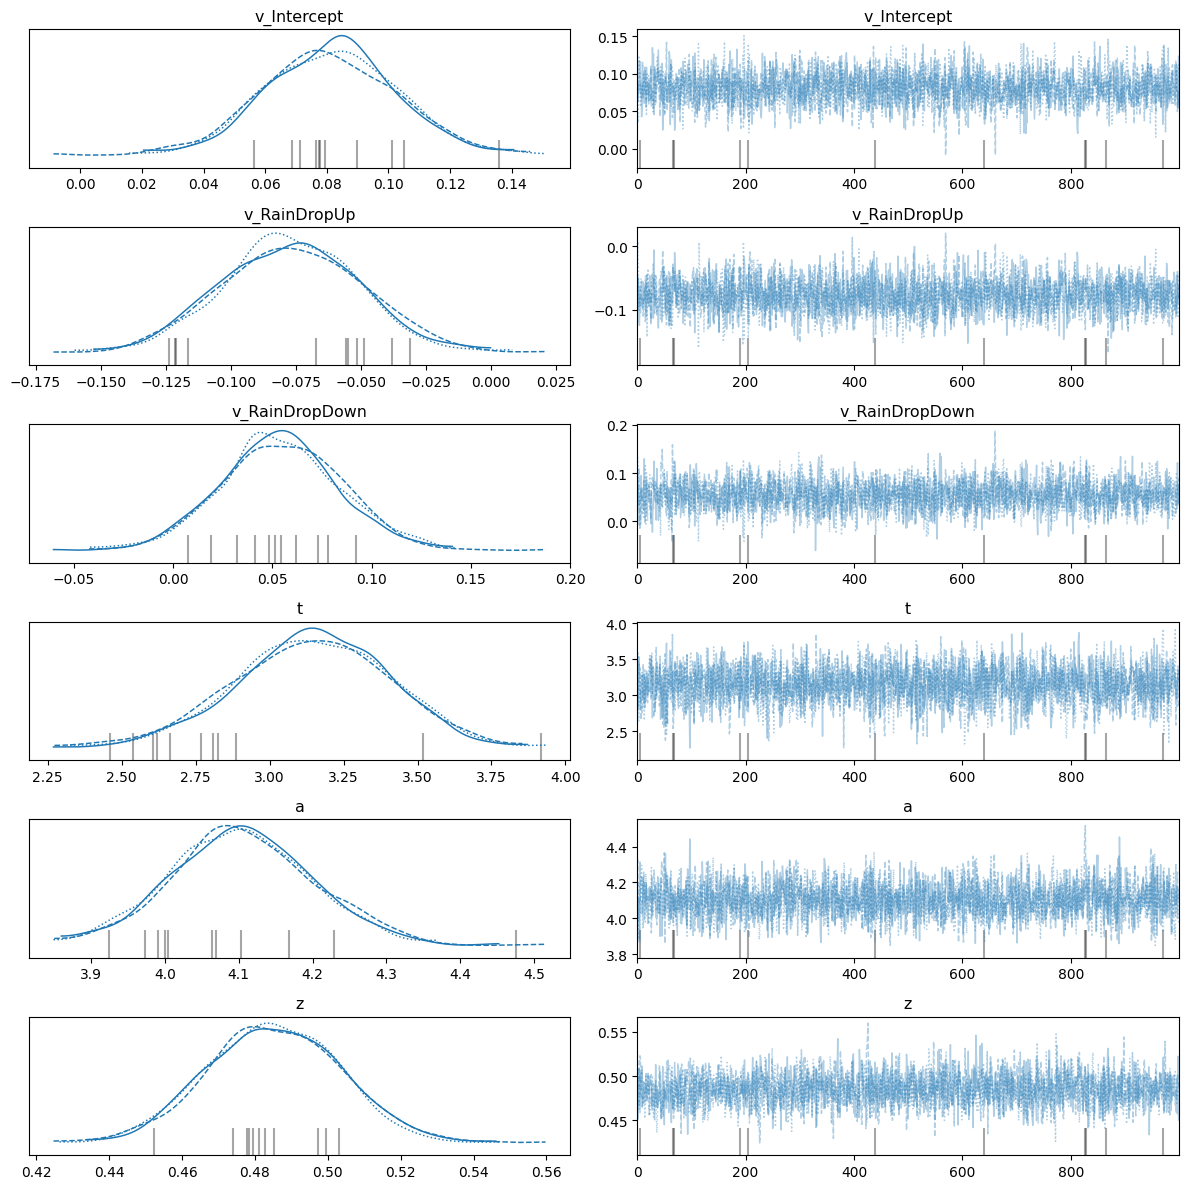

In [ ]:
trace_reg_v["trace_reg_v_1"].plot_trace()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


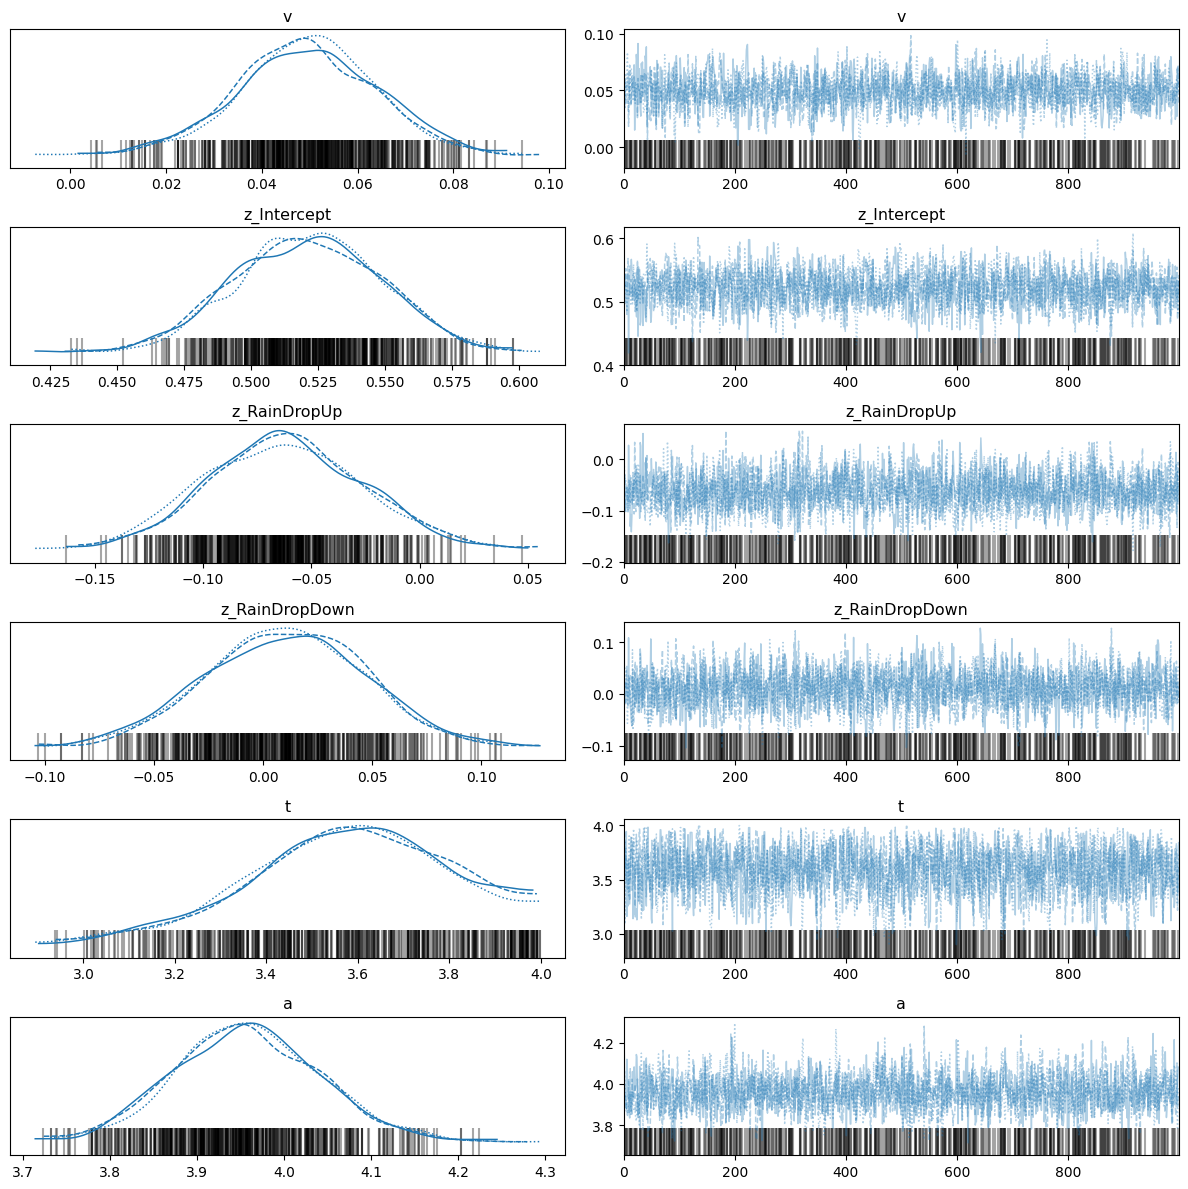

In [ ]:
trace_reg_z["trace_reg_z_1"].plot_trace()

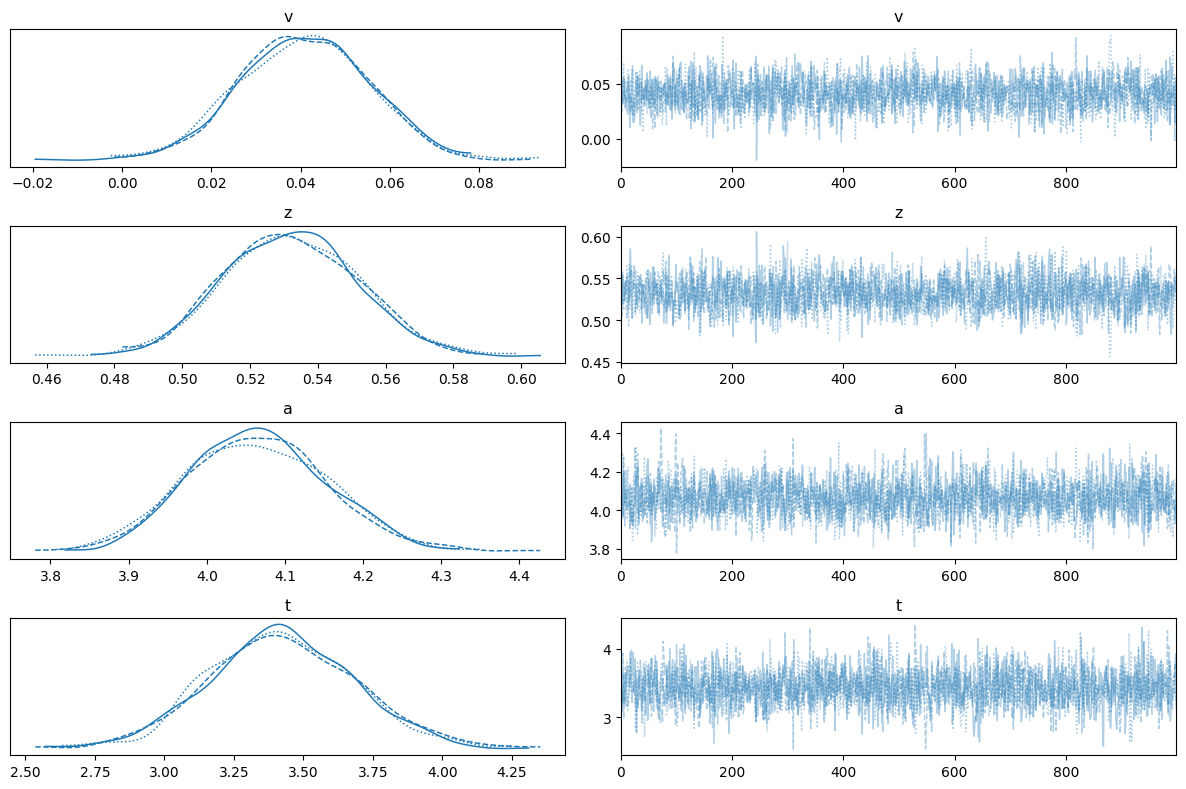

In [ ]:
trace_reg_n["trace_reg_n_2"].plot_trace()

## *Optional*: Model Recovery *(2 bonus points)*







Model Recovery is a crucial process used to validate the robustness and accuracy of a statistical model. This involves checking whether the model, once fitted to data generated by a known process, can accurately recover the parameters.

For our analysis, we constructed a simulated dataset using the varying the drift (v), modifying the starting point (z) and implementing “naive” model. During this process, we engaged in fitting  these simulated models with one another. The objective is to create confusion matrix comparing the simulated models with the fitted models, in order to evaluate the models' comparability and determine if the data produced by a model could be accurately fitted back to the same model.


In [ ]:
%%capture
!pip install hssm

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import hssm
import hssm.plotting
import random
hssm.set_floatX("float32")
import scipy
import time

KeyboardInterrupt: 

### Varying drift Simulated Data & Data Fitting


In this section, we modified the 'v' value for each generated sample to reflect the plausibility.








In [ ]:
# Parameters
v_base = 0.02      # Base drift rate
a = 1              # Threshold
z = 0.5            # Starting point (between 0 and threshold a)
t0 = 0.2           # Non-decision time
trial_size = 100   # Number of trials

# Generating plausibility values for each trial
plausible = np.array([random.choice([-1, 1, 0]) for _ in range(trial_size)])

# Adjusting drift rate based on plausibility for each trial
adjusted_v = [v_base + 0.01 * p for p in plausible]

# true_values for each trial
true_values = [[v, a, z, t0] for v in adjusted_v]


# Create an empty DataFrame with the column names
columns = ['rt', 'response']
sim_d_varying_drift= pd.DataFrame(columns=columns)

# for a given specific true_value generate one sample and append to dataframe
for i,v in enumerate(true_values):
    sim_d_varying_drift.loc[i] = hssm.simulate_data(
        model="ddm",
        theta=v,
        size=1).iloc[0]

# add the plausible column to the dataset
sim_d_varying_drift['plausible'] = plausible
sim_d_varying_drift['plausible'] = sim_d_varying_drift['plausible'].astype('category')

# dummy coding for the plausible
sim_d_varying_drift['RainDropDown'] = (sim_d_varying_drift['plausible'] == 1).astype(int)
sim_d_varying_drift['RainDropUp'] = (sim_d_varying_drift['plausible'] == -1).astype(int)

In [ ]:
# dataset
sim_d_varying_drift

rt  response plausible  RainDropDown  RainDropUp
0   1.296097      -1.0        -1             0           1
1   1.296097      -1.0         1             1           0
2   1.296097      -1.0         1             1           0
3   1.296097      -1.0        -1             0           1
4   1.296097      -1.0         0             0           0
..       ...       ...       ...           ...         ...
95  1.296097      -1.0         0             0           0
96  1.296097      -1.0         0             0           0
97  1.296097      -1.0         0             0           0
98  1.296097      -1.0         1             1           0
99  1.296097      -1.0         1             1           0

[100 rows x 5 columns]

Model's visualization to asses how v is modelded to be dependent on the cateogrical predictors.

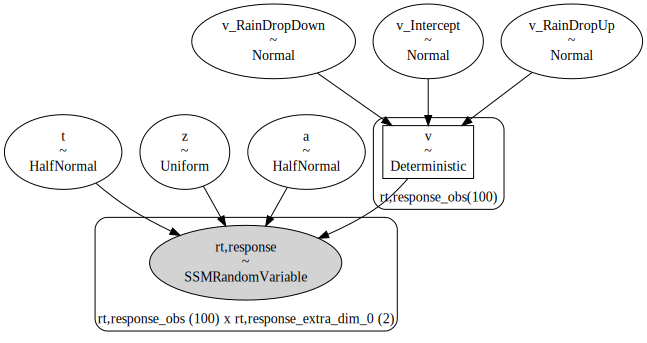

In [ ]:
# graph visualization of our model (v depnding on the stimulus shown)
# This is just an example of how our model look (this section is not repeated in the other sub-sections)
varying_drift_model = hssm.HSSM(
    data=sim_d_varying_drift, # simulated dataset
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

varying_drift_model.graph()

initialization of the three models (varying drift, varying starting point, and naive), MCMC sampling and model comparison.

In [ ]:
%%capture

# initializing the models based on our hypothesis

# v changing with stimulus
varying_drift_model = hssm.HSSM(
    data=sim_d_varying_drift, # simulated dataset
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

# z changing with stimulus
varying_starting_point_model = hssm.HSSM(
    data=sim_d_varying_drift, # simulated dataset
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

# naive model uneffected by the stimuls shown
naive_model = hssm.HSSM(
    data=sim_d_varying_drift, # simulated dataset
)

# The list for extracted weight column from model.comparison
weight_list_varying_drift_sim_data = []

# MCMC sampling for each models, model comparison and extracting the "weights"
for _ in range(4):

    # MCMC sampling varying_drift_model
    varying_drift_model_inference = varying_drift_model.sample(
        sampler="nuts_numpyro", # specific MCMC sampling strategy we are using
        cores=1,                # CPU cores used to run MCMC
        chains=2,               # independent "runs" through the room of parameters
        draws=1000,             # number of samples in sample each chain
        tune=1000,              # additional steps taken in each chain before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),# for model comparison
    )

    # MCMC sampling of varying_starting_point_model
    varying_starting_point_model_inference = varying_starting_point_model.sample(
        sampler="nuts_numpyro",
        cores=1,
        chains=2,
        draws=1000,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
    )

    # MCMC sampling of naive model
    naive_model_inference = naive_model.sample(
        sampler="nuts_numpyro",
        cores=1,
        chains=2,
        draws=1000,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
    )

    # Model comparison between the three models
    model_comparison_varying_drift_sim_data = az.compare(
        {
            "varying drift": varying_drift_model.traces,
            "starting point": varying_starting_point_model.traces,
            "naive": naive_model.traces
        }
    )
    # extracting weights from model.comparison
    weight_list_varying_drift_sim_data.append(dict(model_comparison_varying_drift_sim_data.weight))


ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_inline_composite_constants
ERROR:pytensor.graph.rewriting.basic:node: Composite{...}([1.2960966 ... 1.2960966], ExpandDims{axis=0}.0, [0.5], Sqr.0, ExpandDims{axis=0}.0, [3.1415927e-15], [1.e-15], [6.2831855], [0.31830987], [1])
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pytensor/graph/features.py", line 571, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False, **kwargs)
  File "/usr/local/lib/python3.10/dist-pac

In [ ]:
weight_list_varying_drift_sim_data

[{'starting point': 0.9999999999141427,
  'naive': 0.0,
  'varying drift': 8.585732125254708e-11},
 {'naive': 0.6669571449882388,
  'varying drift': 1.0055661681311565e-11,
  'starting point': 0.3330428550017056},
 {'naive': 1.0,
  'varying drift': 1.3900108841724546e-10,
  'starting point': 0.0},
 {'varying drift': 0.9999999999690392,
  'naive': 0.0,
  'starting point': 3.096078948772174e-11}]

In [ ]:
# extracting the "probabilities" from model comparison and averaging them
weight_list_varying_drift = []
weight_list_starting_point = []
weight_list_naive = []

lst_len = len(weight_list_varying_drift_sim_data)
for i in range(lst_len):
    weight_list_varying_drift.append(weight_list_varying_drift_sim_data[i]['varying drift'])
    weight_list_starting_point.append(weight_list_varying_drift_sim_data[i]['starting point'])
    weight_list_naive.append(weight_list_varying_drift_sim_data[i]['naive'])

# Calculate the average weights for each model type
weight_list_vd_sim_d = [
    np.average(weight_list_varying_drift),
    np.average(weight_list_starting_point),
    np.average(weight_list_naive)
]

In [ ]:
weight_list_vd_sim_d

[0.2500000000509883, 0.33326071373670224, 0.4167392862470597]


### Starting-Point Simulated Data & Data Fitting

In this section, we modified the 'z' value for each generated sample to reflect the plausibility.

In [ ]:
# Parameters
v = 0.02            # drift rate
a = 1               # Threshold
z_base = 0.5        # Base Starting point
t0 = 0.2            # Non-decision time
trial_size = 100    # Number of trials

# Generating plausibility values for each trial
plausible = np.array([random.choice([-1, 1, 0]) for _ in range(trial_size)])

# Adjusting Starting point based on plausibility for each trial
adjusted_z = [z_base + 0.1 * p for p in plausible]

# true_values for each trial
true_values = [[v, a, z, t0] for z in adjusted_z]

# Create an empty DataFrame with the column names
columns = ['rt', 'response']
sim_d_starting_point= pd.DataFrame(columns=columns)

# for given specific true_value generate one sample and append to dataframe
for i,v in enumerate(true_values):
    sim_d_starting_point.loc[i] = hssm.simulate_data(
        model="ddm",
        theta=v,
        size=1).iloc[0]

# add the plausible column to the dataset
sim_d_starting_point['plausible'] = plausible
sim_d_starting_point['plausible'] = sim_d_starting_point['plausible'].astype('category')

# dummy coding for the plausible
sim_d_starting_point['RainDropDown'] = (sim_d_starting_point['plausible'] == 1).astype(int)
sim_d_starting_point['RainDropUp'] = (sim_d_starting_point['plausible'] == -1).astype(int)

In [ ]:
sim_d_starting_point

rt  response plausible  RainDropDown  RainDropUp
0   0.971982       1.0         0             0           0
1   0.971982       1.0         0             0           0
2   0.947983       1.0         1             1           0
3   1.053981       1.0        -1             0           1
4   1.053981       1.0        -1             0           1
..       ...       ...       ...           ...         ...
95  0.947983       1.0         1             1           0
96  0.971982       1.0         0             0           0
97  1.053981       1.0        -1             0           1
98  0.971982       1.0         0             0           0
99  1.053981       1.0        -1             0           1

[100 rows x 5 columns]

initialization of the three models (varying drift, varying starting point, and naive), MCMC sampling and model comparison.

In [ ]:
%%capture

# initializing the models based on our hypothesis

# v changing with stimulus
varying_drift_model = hssm.HSSM(
    data=sim_d_starting_point, # simulated dataset
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

# z changing with stimulus
varying_starting_point_model = hssm.HSSM(
    data=sim_d_starting_point, # simulated dataset
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

# naive model uneffected by the stimuls shown
naive_model = hssm.HSSM(
    data=sim_d_starting_point, # simulated dataset
)

# The list for extracted weight column from model.comparison
weight_list_starting_point_data = []

# MCMC sampling for each models, model comparison and extracting the "weights"

for _ in range(4):

    # MCMC sampling varying_drift_model
    varying_drift_model_inference = varying_drift_model.sample(
        sampler="nuts_numpyro", # specific MCMC sampling strategy we are using
        cores=1,                # CPU cores used to run MCMC
        chains=2,               # independent "runs" through the room of parameters
        draws=1000,             # number of samples in sample each chain
        tune=1000,              # additional steps taken in each chain before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),# for model comparison
    )

    # MCMC sampling of varying_starting_point_model
    varying_starting_point_model_inference = varying_starting_point_model.sample(
        sampler="nuts_numpyro",
        cores=1,
        chains=2,
        draws=1000,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
    )

    # MCMC sampling of naive model
    naive_model_inference = naive_model.sample(
        sampler="nuts_numpyro",
        cores=1,
        chains=2,
        draws=1000,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
    )

    # Model comparison between the three models
    model_comparison_starting_point_sim_data = az.compare(
        {
            "varying drift": varying_drift_model.traces,
            "starting point": varying_starting_point_model.traces,
            "naive": naive_model.traces
        }
    )

    # extracting weights from model.comparison
    weight_list_starting_point_data.append(dict(model_comparison_starting_point_sim_data.weight))


In [ ]:
weight_list_starting_point_data

[{'varying drift': 0.6093914620660987,
  'naive': 0.3906085379339173,
  'starting point': 0.0},
 {'naive': 0.3987902043674716,
  'varying drift': 1.6150776861695475e-14,
  'starting point': 0.6012097956325122},
 {'naive': 0.0,
  'varying drift': 0.5790371044531705,
  'starting point': 0.42096289554682953},
 {'naive': 0.0,
  'varying drift': 0.3312372739330901,
  'starting point': 0.6687627260669099}]

In [ ]:
# extracting the "probabilities" from model comparison and averaging them
weight_list_varying_drift = []
weight_list_starting_point = []
weight_list_naive = []

lst_len = len(weight_list_starting_point_data)

for i in range(lst_len):
    weight_list_varying_drift.append(weight_list_starting_point_data[i]['varying drift'])
    weight_list_starting_point.append(weight_list_starting_point_data[i]['starting point'])
    weight_list_naive.append(weight_list_starting_point_data[i]['naive'])

# Calculate the average weights for each model type
weight_list_sp_sim_d = [
    np.average(weight_list_varying_drift),
    np.average(weight_list_starting_point),
    np.average(weight_list_naive)
]

In [ ]:
weight_list_sp_sim_d

[0.3799164601130939, 0.42273385431156285, 0.1973496855753472]

### Naive Model Simulated Data & Data Fitting

In this section, we implemented the naive ddm model.

In [ ]:
# Parameters
v = 0.02           # drift rate
a = 1              # Threshold
z = 0.5            # Starting point
t0 = 0.2           # Non-decision time
trial_size = 100   # Number of trials

# Generating plausibility values for each trial
plausible = np.array([random.choice([-1, 1, 0]) for _ in range(trial_size)])

# true_values for each trial
true_values = [v, a, z, t0]

# Simulating data
sim_d_naive= hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=100)

# add the plausible column to the dataset
sim_d_naive['plausible'] = plausible
sim_d_naive['plausible'] = sim_d_naive['plausible'].astype('category')

# dummy coding for the plausible
sim_d_naive['RainDropDown'] = (sim_d_naive['plausible'] == 1).astype(int)
sim_d_naive['RainDropUp'] = (sim_d_naive['plausible'] == -1).astype(int)

sim_d_naive

rt  response plausible  RainDropDown  RainDropUp
0   1.193242       1.0        -1             0           1
1   0.733405      -1.0        -1             0           1
2   0.695390       1.0        -1             0           1
3   1.062398      -1.0         0             0           0
4   2.468832       1.0         0             0           0
..       ...       ...       ...           ...         ...
95  0.438435      -1.0        -1             0           1
96  1.685449      -1.0        -1             0           1
97  0.668333      -1.0         1             1           0
98  1.077800      -1.0        -1             0           1
99  0.635795       1.0        -1             0           1

[100 rows x 5 columns]

initialization of the three models (varying drift, varying starting point, and naive), MCMC sampling and model comparison.

In [ ]:
%%capture

# initializing the models based on our hypothesis

# v changing with stimulus
varying_drift_model = hssm.HSSM(
    data=sim_d_naive, # simulated dataset
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

# z changing with stimulus
varying_starting_point_model = hssm.HSSM(
    data=sim_d_naive, # simulated dataset
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

# naive model uneffected by the stimuls shown
naive_model = hssm.HSSM(
    data=sim_d_naive, # simulated dataset
)

# The list for extracted weight column from model.comparison
weight_list_naive_sim_data = []

for _ in range(4):

    # MCMC sampling varying_drift_model
    varying_drift_model_inference = varying_drift_model.sample(
        sampler="nuts_numpyro", # specific MCMC sampling strategy we are using
        cores=1,                # CPU cores used to run MCMC
        chains=2,               # independent "runs" through the room of parameters
        draws=1000,             # number of samples in sample each chain
        tune=1000,              # additional steps taken in each chain before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),# for model comparison
    )

    # MCMC sampling of varying_starting_point_model
    varying_starting_point_model_inference = varying_starting_point_model.sample(
        sampler="nuts_numpyro",
        cores=1,
        chains=2,
        draws=1000,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
    )

    # MCMC sampling of naive model
    naive_model_inference = naive_model.sample(
        sampler="nuts_numpyro",
        cores=1,
        chains=2,
        draws=1000,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
    )

    # Model comparison between the three models
    model_comparison_naive_sim_data = az.compare(
        {
            "varying drift": varying_drift_model.traces,
            "starting point": varying_starting_point_model.traces,
            "naive": naive_model.traces
        }
    )
    # extracting weights from model.comparison
    weight_list_naive_sim_data.append(dict(model_comparison_naive_sim_data.weight))


In [ ]:
# extracting the "probabilities" from model comparison and averaging them

weight_list_varying_drift = []
weight_list_starting_point = []
weight_list_naive = []

lst_len = len(weight_list_naive_sim_data)

for i in range(lst_len):
    weight_list_varying_drift.append(weight_list_naive_sim_data[i]['varying drift'])
    weight_list_starting_point.append(weight_list_naive_sim_data[i]['starting point'])
    weight_list_naive.append(weight_list_naive_sim_data[i]['naive'])


# Calculate the average weights for each model type
weight_list_naive_sim_d = [
    np.average(weight_list_varying_drift),
    np.average(weight_list_starting_point),
    np.average(weight_list_naive)
]



In [ ]:
weight_list_naive_sim_d

[6.8833827526759706e-15, 0.20240335948224908, 0.7975966405177451]

### Confusion Matrix

The section below will get the weghts from the model comparison and draw a confusion matrix.

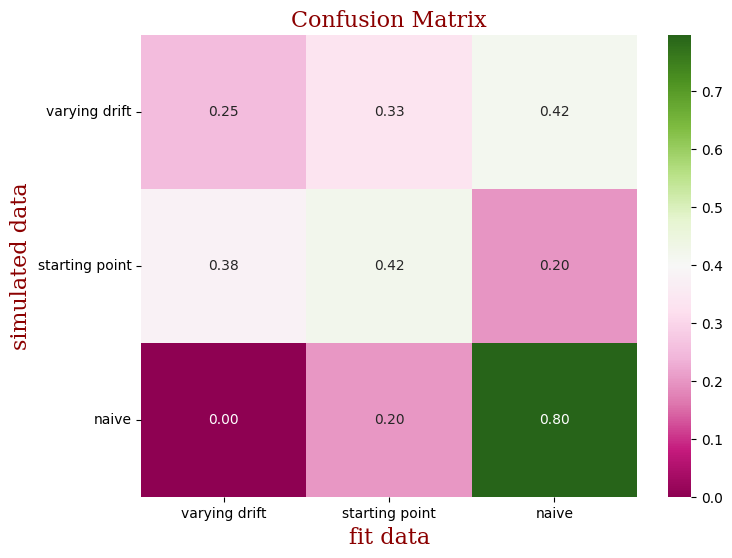

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


matrix = [weight_list_vd_sim_d, weight_list_sp_sim_d, weight_list_naive_sim_d]

# Create a 3x3 matrix of zeros
# matrix = np.full((3, 3), np.nan)


# for i in range(3):
#     matrix[i,0] = weight_list[i]

# Plotting the matrix using seaborn's heatmap function
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="PiYG" ,cbar=True)
plt.title("Confusion Matrix", fontdict=font)
plt.xticks(ticks=np.arange(3) + 0.5, labels=["varying drift","starting point","naive"], rotation=0, ha='center')
plt.yticks(ticks=np.arange(3) + 0.5, labels=["varying drift","starting point","naive"], rotation=0)
# Add titles beside the x and y axes
plt.xlabel('fit data', fontdict=font)
plt.ylabel('simulated data', fontdict=font)
plt.show()


## Model Comparison *(5 points)*

Now, we have come to the very last section of this notebook which is the Model Comparison section. In this section, we will perform the comparison between the Varying Drift model, Varying Starting Point model and the Naive model by fitting these three DDMs to our own generated experimental data using Marcov Chain Monte Carlo (MCMC) sampling. We are gonna make use of the HSSM toolbox as before for fitting our sequential sampling or drift diffusion models in order to perform the final comparison. We will start the following section by first reading our experimental data and transforming it into a dataframe using pandas. After that, we will instantiate our model using the HSSM class using the converted pandas dataframe dataset. This instantiation will be performed on all our three models followed by applying the ".sample()" function in order to generate the posterior samples by making usage of the "nuts_numpyro" backend. Finally, the model comparison will be performed by using the Arviz module "az.compare()" which will generate the traces for each of the parameters in all the three models, so that we can visualize all of the posterior samples using appropriate posterior distributions.

In [ ]:
!pip install arviz
!pip install --upgrade numpyro
!pip install --upgrade arviz numpyro
!pip install --upgrade numpyro numpy scipy
!pip install --upgrade setuptools
!pip install hssm
!pip install scipy

  Using cached numpyro-0.13.2-py3-none-any.whl (312 kB)
  Attempting uninstall: numpyro
    Found existing installation: numpyro 0.12.1
    Uninstalling numpyro-0.12.1:
      Successfully uninstalled numpyro-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hssm 0.2.0 requires numpyro<0.13.0,>=0.12.1, but you have numpyro 0.13.2 which is incompatible.
  Using cached arviz-0.17.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: arviz
    Found existing installation: arviz 0.14.0
    Uninstalling arviz-0.14.0:
      Successfully uninstalled arviz-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hssm 0.2.0 requires arviz<0.15.0,>=0.14.0, but you have arviz 0.17.0 which is incompatible.
hssm 0.2.0 requires numpyro<0.13.0,>=0.12.

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import hssm
import numpy as np
import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp
import jax.random
from IPython.display import display

In the following block of code, pandas is used to read a CSV file that contains all of the data generated by the group members who participated in the rain drop and circle experiment. The temporal resolution is changed to seconds, in order to be compatible with the hssm implementation

In [ ]:
# Read the .csv file called "df.csv" which contains the data of all the participants and convert them to a pandas dataframe.

df_secs = df.copy()

df_secs["rt"]=df_secs["rt"]/1000
df_secs

rt  response  plausible  RainDropDown  RainDropUp
0    1.182         1          1             1           0
1    0.578         1          1             1           0
2    0.767         1          0             0           0
3    0.443         1          1             1           0
4    0.558         1          0             0           0
..     ...       ...        ...           ...         ...
702  0.721         1         -1             0           1
703  0.619         1          0             0           0
704  0.881         1         -1             0           1
705  0.549         1         -1             0           1
706  0.605        -1          1             1           0

[707 rows x 5 columns]

In the following block of code, we created and instantiated our Varying Drift model using the dataframe that contains all of our experimental data by using the HSSM Module of the hssm (Hierarchical Sequential Sampling Model) toolbox. After that, we visualized the graph of the Varying Drift model using the .graph() function. This graph helped us in seeing the distributions of all the basic paramters along with the observed reaction times and choices. The Varying Drift model assumes that the Drift Rate (v) is the independent variable and the formula "v ~ 1 + RainDropDown + RainDropUp" denotes that 'v' varies as the function of the upward (RainDropUp) and downward (RainDropDown) values of our dataset (the Rain Drop stimuli movement).

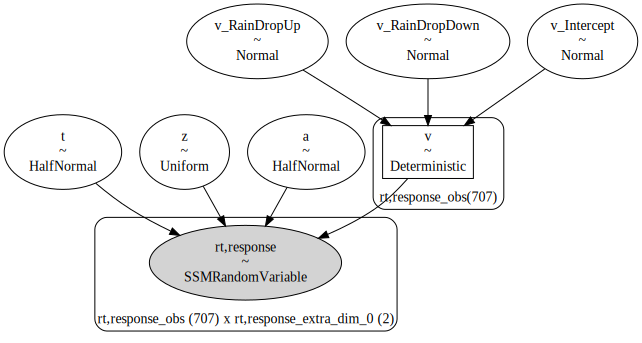

In [ ]:
# Instantiate the Varying Drift model by using the HSSM module of the hssm toolbox with the pandas dataframe containing the experimental data

varying_drift_model = hssm.HSSM(
    data=df_secs,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

varying_drift_model.graph()

In the following block of code, we created and instantiated our Varying Starting Point model using the dataframe that contains all of our experimental data by using the HSSM Module of the hssm (Hierarchical Sequential Sampling Model) toolbox. After that, we visualized the graph of the Varying Starting Point model using the .graph() function. This graph helped us in seeing the distributions of all the basic paramters along with the observed reaction times and choices. The Varying Starting Point model assumes that the Starting Point (z) is the independent variable and the formula "z ~ 1 + RainDropDown + RainDropUp" denotes that 'z' varies as the function of the upward (RainDropUp) and downward (RainDropDown) values of our dataset (the Rain Drop stimuli movement).


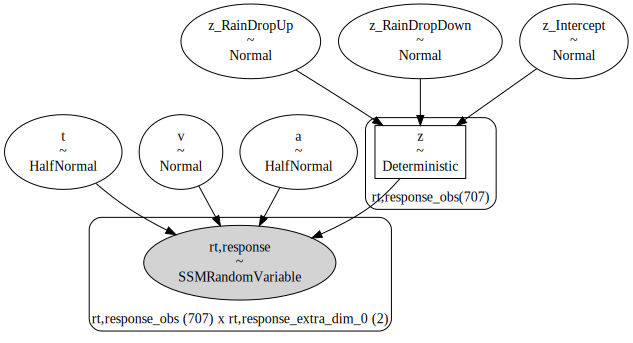

In [ ]:
# Instantiate the Varying Starting Point model by using the HSSM module of the hssm toolbox with the pandas dataframe containing the experimental data

varying_starting_point_model = hssm.HSSM(
    data=df_secs,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + RainDropDown + RainDropUp",
        }
    ],
)

varying_starting_point_model.graph()

In the following block of code, we created and instantiated our Naive DDM model using the dataframe that contains all of our experimental data by using the HSSM Module of the hssm (Hierarchical Sequential Sampling Model) toolbox. After that, we visualized the graph of the Naive DDM model using the .graph() function. This graph helped us in seeing the distributions of the basic paramters along with the observed reaction times and choices. The Naive Model assumes the value of the Threshold(a) parameter as 1.

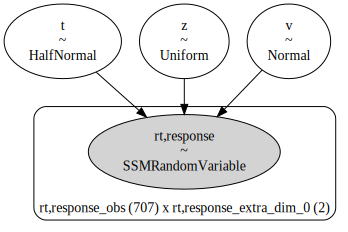

In [ ]:
# Instantiate the Naive model by using the HSSM module of the hssm toolbox with the pandas dataframe containing the experimental data

naive_model = hssm.HSSM(
    data= df_secs,
    model="ddm",
    a = 1,
)

naive_model.graph()

In [ ]:
# Fit all the three models by drawing samples using MCMC
varying_drift_model_inference = varying_drift_model.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

naive_model_inference  = naive_model.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

# In the following code block, we have used the compare module of Arviz library for comparing the models.

model_comparison = az.compare(
    {
        "varying drift": varying_drift_model.traces,
        "varying starting point": varying_starting_point_model.traces,
        "naive model" : naive_model.traces,
    }
)



  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


In [ ]:
model_comparison

rank    elpd_loo     p_loo  elpd_diff        weight  \
naive model                0 -149.357171  3.696729   0.000000  1.000000e+00   
varying starting point     1 -151.554075  7.191621   2.196904  0.000000e+00   
varying drift              2 -151.880804  7.307885   2.523633  4.662937e-15   

                               se       dse  warning scale  
naive model             33.287990  0.000000    False   log  
varying starting point  33.938666  1.838696    False   log  
varying drift           34.115254  1.905678    False   log

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept     2.530  0.174   2.221    2.865      0.007    0.005     541.0   
v_RainDropDown -0.067  0.147  -0.320    0.225      0.004    0.003    1140.0   
v_RainDropUp   -0.134  0.147  -0.413    0.131      0.005    0.003    1049.0   
t               0.267  0.021   0.228    0.302      0.001    0.001     507.0   
z               0.404  0.034   0.343    0.467      0.001    0.001     738.0   
a               1.074  0.060   0.955    1.179      0.003    0.002     539.0   

                ess_tail  r_hat  
v_Intercept        820.0    1.0  
v_RainDropDown    1295.0    1.0  
v_RainDropUp      1270.0    1.0  
t                  892.0    1.0  
z                  924.0    1.0  
a                  561.0    1.0

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


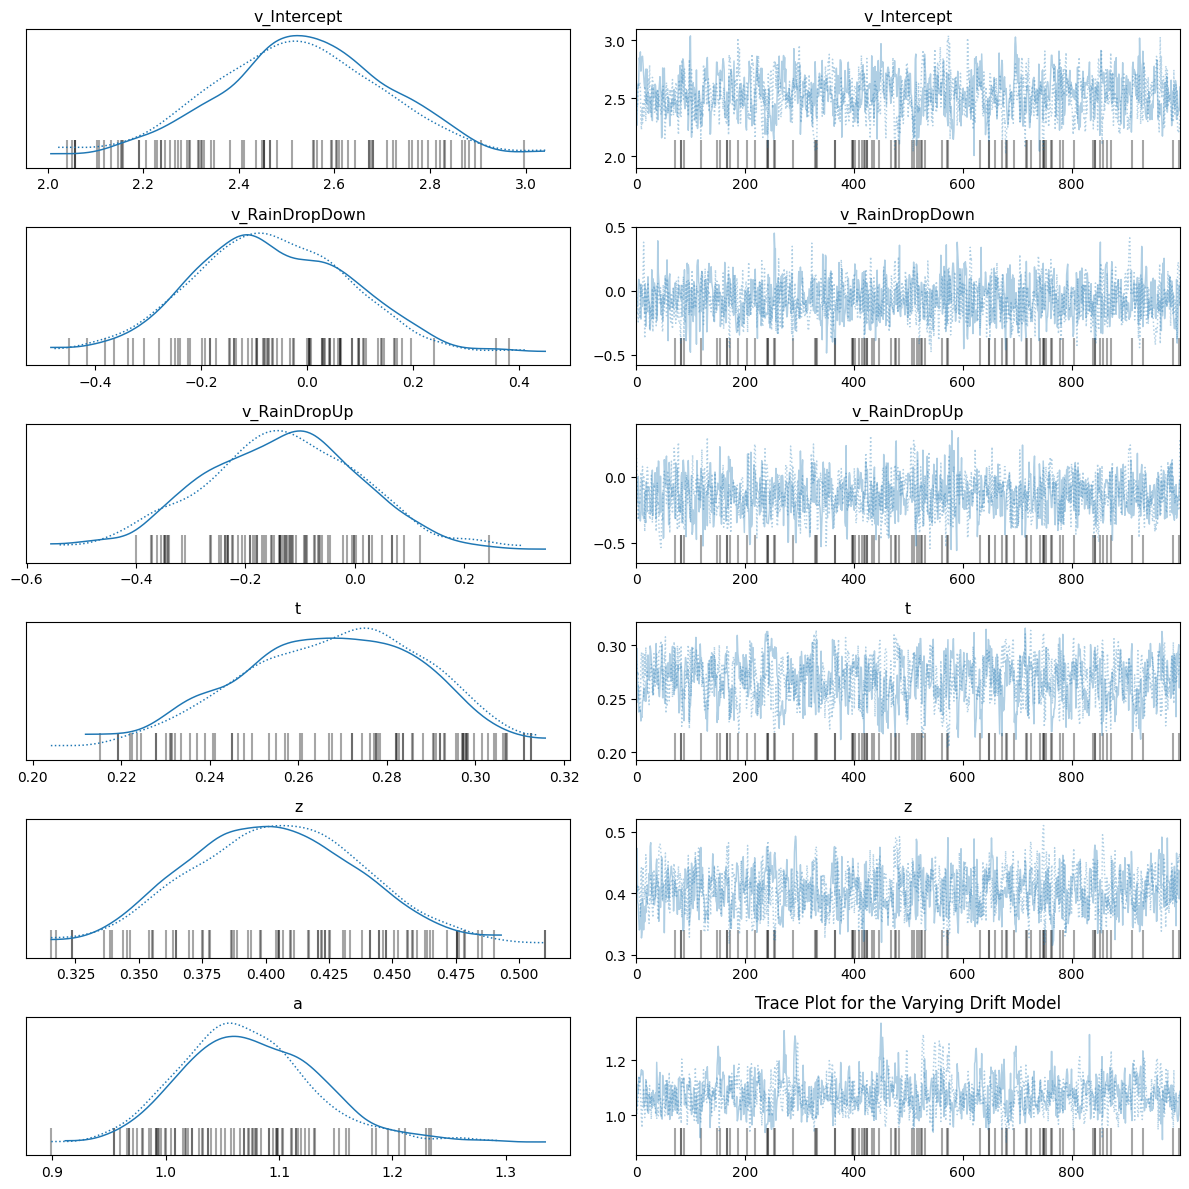

In [ ]:
import matplotlib.pyplot as plt

# show fitted parameters
display(az.summary(varying_drift_model.traces))

# Plot trace for the varying drift model
varying_drift_model.plot_trace()
plt.title("Trace Plot for the Varying Drift Model")
plt.show()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v               2.449  0.157   2.157    2.741      0.006    0.004     617.0   
z_Intercept     0.417  0.035   0.352    0.480      0.001    0.001     720.0   
z_RainDropDown -0.001  0.025  -0.049    0.042      0.001    0.001     958.0   
z_RainDropUp   -0.028  0.025  -0.074    0.019      0.001    0.001    1170.0   
t               0.271  0.020   0.237    0.309      0.001    0.001     595.0   
a               1.066  0.057   0.966    1.178      0.002    0.002     690.0   

                ess_tail  r_hat  
v                  754.0    1.0  
z_Intercept       1016.0    1.0  
z_RainDropDown    1001.0    1.0  
z_RainDropUp      1016.0    1.0  
t                  748.0    1.0  
a                  972.0    1.0

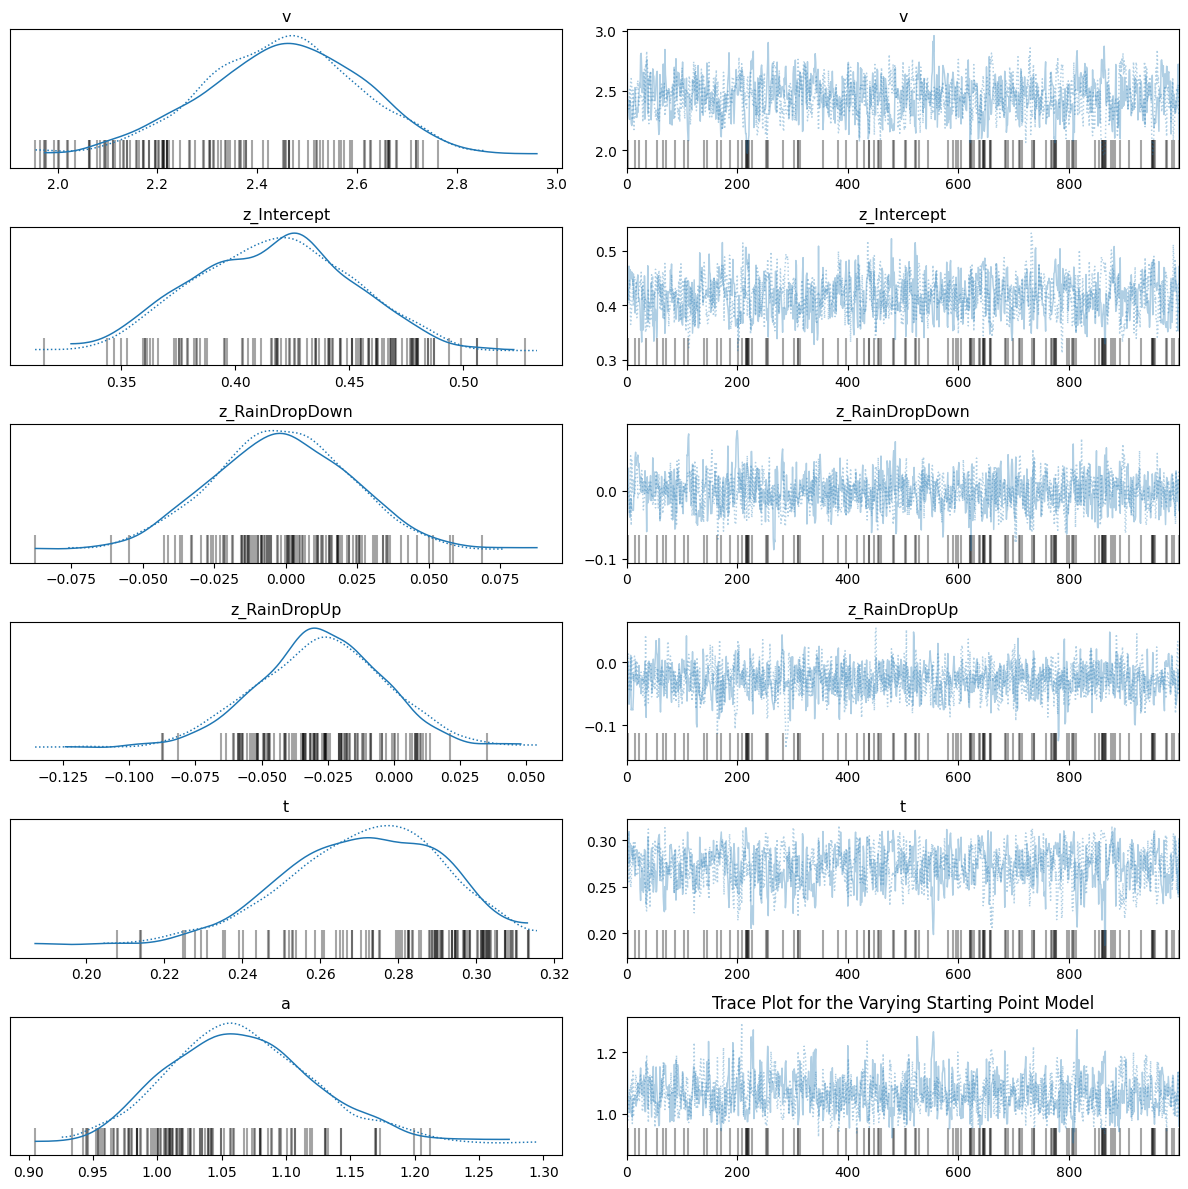

In [ ]:
# Plot trace for the varying starting point model

# show fitted parameters
display(az.summary(varying_starting_point_model.traces))

varying_starting_point_model.plot_trace()
plt.title("Trace Plot for the Varying Starting Point Model")
plt.show()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v               2.449  0.157   2.157    2.741      0.006    0.004     617.0   
z_Intercept     0.417  0.035   0.352    0.480      0.001    0.001     720.0   
z_RainDropDown -0.001  0.025  -0.049    0.042      0.001    0.001     958.0   
z_RainDropUp   -0.028  0.025  -0.074    0.019      0.001    0.001    1170.0   
t               0.271  0.020   0.237    0.309      0.001    0.001     595.0   
a               1.066  0.057   0.966    1.178      0.002    0.002     690.0   

                ess_tail  r_hat  
v                  754.0    1.0  
z_Intercept       1016.0    1.0  
z_RainDropDown    1001.0    1.0  
z_RainDropUp      1016.0    1.0  
t                  748.0    1.0  
a                  972.0    1.0

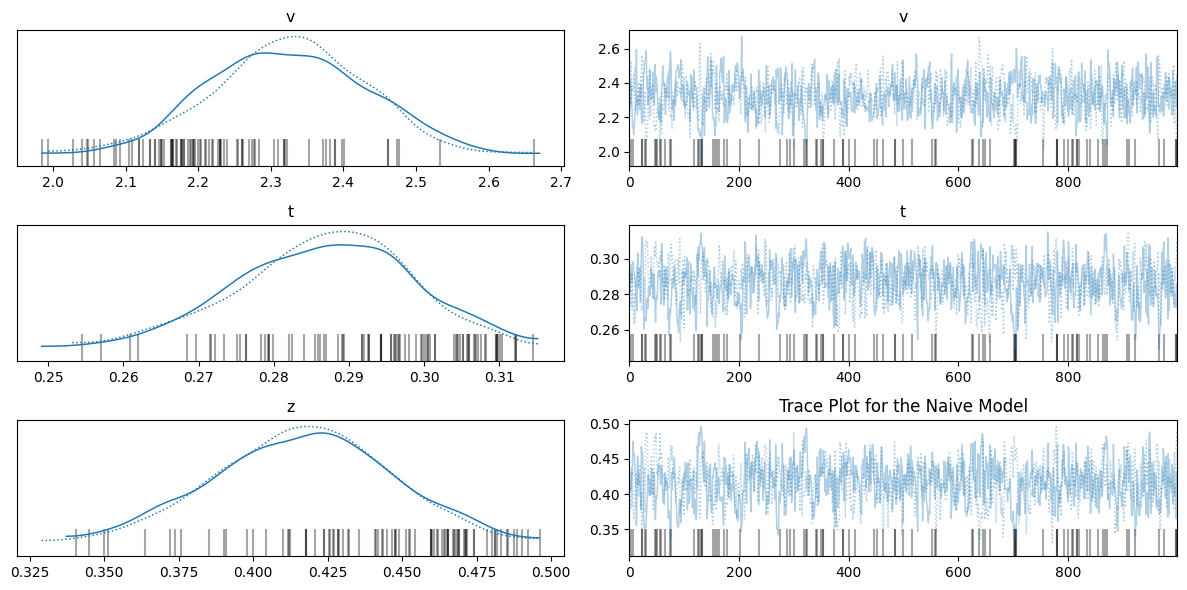

In [ ]:
# Plot trace for the naive model

# show fitted parameters
display(az.summary(varying_starting_point_model.traces))

naive_model.plot_trace()
plt.title("Trace Plot for the Naive Model")
plt.show()
